In [1]:
## Exploring sklearn's DBSCAN
## Goal: For multiple samples, Across different param combos, focussing on different data slices 
##       --> Compile splits, compile plots
## Specify reasoned parameter ranges, for each data slice


In [1]:
import torch
import numpy as np
import sklearn
import os, errno
import sys
from datetime import datetime
import time
import csv

import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

from Instseg_model import MultiLayerFastLocalGraphModelV2 as model1
from dataset import pcloader
from graph_generation import gen_multi_level_local_graph_v3

from math import floor, ceil
from scipy.stats import mode

import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from plot_utils import add_staple_patch

In [3]:
## CLASSIFICATION INFERENCE
##  - High Level Config Settings
##  - Singular Function to get predictions
##  - Post Processing for Non Background points
##  - Plot and Save Both Predictions

## LOOPING THROUGH DIFFERENT CLUSTERING RUNS FOR EACH DATA SLICE
##  - High Level Config Setting
##  - Single Function for Run through param matrix --> log and Plots for all samples
##     - Plots in the Same Folder
##     - CSV of Cluster and Cluster Count

## ORGANIZING OUTPUT DATA
## Single CSV : FileName, SampleTag, slice, param1, param2, paramX,-1_count, 0_count, etc
## Directory for Plots prefixed with SampleTag + DataColHeaders + paramCombo

In [4]:
## CLASSIFICATION INFERENCE

## Hight Level Config Settings

graph_gen_kwargs = {
	'add_rnd3d': True,
	'base_voxel_size': 0.8,
	'downsample_method': 'random',
	'level_configs': [
		{'graph_gen_kwargs': {'num_neighbors': 64, 'radius': 0.4},
		 'graph_gen_method': 'disjointed_rnn_local_graph_v3',
		 'graph_level': 0,
		 'graph_scale': 1},
		{'graph_gen_kwargs': {'num_neighbors': 192, 'radius': 1.2},
		 'graph_gen_method': 'disjointed_rnn_local_graph_v3',
		 'graph_level': 1,
		 'graph_scale': 1}]
}

def configure_model(model_params_path, max_cls_classes=3, max_inst_classes=7, verbose=False):
    a = time.time()
    model = model1(num_classes=max_cls_classes, max_instance_no=max_inst_classes)
    if os.path.isfile(model_params_path):
        model.load_state_dict(torch.load(model_params_path))
    else:
        if verbose:
            print(f"[ModelParamPathError] {model_params_path} does not exist")
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), model_params_path)
    b = time.time()
    if verbose:
        print(f"Model Setup Time (secs) : {b-a}")
    return model

def classify_scan(model, scan_path, verbose=False):
    """
    Returns 
     - the x|y|z|cls|inst for all keypoints in the cloud as a Kx5 array
     - and also as a dict
    """
    a = time.time()
    pointxyz, offset = pcloader(scan_path)
    vertex_coord_list, keypoint_indices_list, edges_list = \
    gen_multi_level_local_graph_v3(pointxyz,0.6,graph_gen_kwargs['level_configs'])
    last_layer_v = vertex_coord_list[-1]

    ## conversions: type precision
    vertex_coord_list = [p.astype(np.float32) for p in vertex_coord_list]
    keypoint_indices_list = [e.astype(np.int32) for e in keypoint_indices_list]
    edges_list = [e.astype(np.int32) for e in edges_list]

    ## conversions: numpy array to tensor
    vertex_coord_list = [torch.from_numpy(item) for item in vertex_coord_list]
    keypoint_indices_list = [torch.from_numpy(item).long() for item in keypoint_indices_list]
    edges_list = [torch.from_numpy(item).long() for item in edges_list]

    ## Run graph through GNN model
    batch = (vertex_coord_list, keypoint_indices_list, edges_list)
    cls_seg, inst_seg = model(*batch)

    ## Filter classification probabilities for the most probable
    cls_preds = torch.argmax(cls_seg, dim=1)
    inst_preds = torch.argmax(inst_seg, dim=1)
    
    ## expand the shape of the array
    cls_preds = np.expand_dims(cls_preds, axis=1)
    inst_preds = np.expand_dims(inst_preds, axis=1)

    b = time.time()
    if verbose:
        print("Scan Inference Time (secs): ", b-a)
        print()
    
    return np.hstack((last_layer_v, cls_preds, inst_preds)),\
            {'vertices': last_layer_v, 'cls_preds': cls_preds, 'inst_preds': inst_preds}

def filter_out_background(scan_data):
    non_bg_idx = ~np.logical_or(scan_data[:, 3] == 0, scan_data[:, 4] == 0)
    non_bg = scan_data[non_bg_idx]
    return non_bg, non_bg_idx

def count_cluster_by_instance_prediction(scan_data, threshold_factor=0.5):
    """
    Returns a cluster_count ie the number of clusters on the cls field/col that has at least a threshold number of members
    Also: a dict of intermediary/final counts, types and thresholds
    """
    inst, inst_count = np.unique(scan_data[:,4], return_counts=True)
    inst_count_threshold = threshold_factor * np.mean(inst_count)
    reduced_idx = np.where(inst_count > inst_count_threshold)
    cluster_count = np.sum(inst_count > inst_count_threshold)
    reduced = inst[reduced_idx]
    
    return cluster_count, {'orig_insts': inst,
                           'orig_inst_ct': inst_count,
                           'inst_ct_thresh': inst_count_threshold,
                           'reduced_insts': reduced}

def _plot(path, points, values, title="", caption="", overlay_points=None ):
    """
    path - output path
    points - matrix of x, y, etc cols
    values - assigned value per point ie predicted/truth cls/inst
    [optional] overlay_points = [{"xs":[], "ys":[], "cs":_, "marker":_, "label"=_}, ...]
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title(title)
    im = ax.scatter(points[:,0], points[:,1],s=0.25,c=values)
    
#     _im = None
    if overlay_points:    
        for pts in overlay_points:
#             _im = ax.scatter(pts["xs"], pts["ys"], s=2, c=pts["cs"], marker=pts["marker"])
            _im = ax.scatter(pts["xs"], pts["ys"], s=pts["ss"], c=pts["cs"], marker=pts["marker"])
#             ims.append(_im)
            
        

    ax.set_xlabel("x [mm]")
    ax.set_ylabel("y [mm]")
# #     leg_els = im.legend_elements()
# #     if _im:
# #         leg_els += _im.legend_elements()
# #         print("leg_els")
# #         print(leg_els)
# #         print("_im.legend_elements()")
# #         print(_im.legend_elements())
# #         print("im.legend_elements()")
# #         print(im.legend_elements())
        
    legend_ = ax.legend(*im.legend_elements(), bbox_to_anchor=(1.1, 1), loc="upper right")
# #     legend_ = ax.legend(*leg_els, bbox_to_anchor=(1.1, 1), loc="upper right")
    ax.add_artist(legend_)
# #     for _im in ims:
# #         _legend = ax.legend(*_im.legend_elements(), bbox_to_anchor=(1.1, 1), loc="upper right")
# #         ax.add_artist(_legend)

    ax.text(0.5, -0.5, caption, style='italic', \
        horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
    axes=plt.gca()
    axes.set_aspect(1)
    if path:
        plt.savefig(path, dpi=150)
        plt.close()
        plt.cla()
        plt.clf()
    else:
        plt.show
    
def save_prediction_plots(non_bg_matrix, cls_tag=None, inst_tag=None, cls_col=3, inst_col=4, dir_path="./plots/", verbose=False):
    """
    non_bg_matrix -- x|y|z|cls|inst
    // tag -- eg A_xycls_eps0_45_50
    tag -- eg A_xycls
    """
    
    ## [RED FLAG] - what if dir_path comes through as None
    f_tag = "[save_prediction_plots]"
    f_msg = []
    
    if not (cls_tag and inst_tag):
        print("[ERROR] No specfied cls_tag or inst_tag args. Plots not generated")
    else:
        if cls_tag:
            cls_output_path = dir_path+cls_tag+".png" if dir_path else None
            _plot(cls_output_path, non_bg_matrix[:, :2], non_bg_matrix[:, cls_col], title=cls_tag)
            f_msg.append(cls_output_path)

        if inst_tag:
            inst_output_path = dir_path+inst_tag+".png" if dir_path else None
            _plot(inst_output_path, non_bg_matrix[:, :2], non_bg_matrix[:, inst_col], title=inst_tag)
            f_msg.append(inst_output_path)

        if verbose:
#             f_msg = ", ".join(f_msg)
            print(f"{f_tag}: Done --> {f_msg}")
    

def run_preclustering(model, scan_path, sample_tag="", dir_path="./plots"):
    """
    Runs the scan through the model
    Filters out the background predictions
    Plots cls and inst predictions post filtering and saves plots to file
    Returns the Nx5 data of non-background points --> x|y|z|cls|inst
    """
    # KX5 array --> x|y|z|cls|inst
    scan_data, _ = classify_scan(model, scan_path, verbose=True)
    
    # non bg NX5 array --> x|y|z|cls|inst
    scan_data, _ = filter_out_background(scan_data)
    
    ## [RED FLAG] - No use of the cluster_count or data
    _, cluster_data = count_cluster_by_instance_prediction(scan_data)
    
    ## [RED FLAG] what if dir_path specified as None. Need to catch this cas
    save_prediction_plots(scan_data, cls_tag=sample_tag+"_xycls", inst_tag=sample_tag+"_xyinst", dir_path=dir_path)
    return scan_data, {"0_scan": scan_path, "0_tag":sample_tag}

In [8]:
## Test Running a sample

## Run Settings
model_params_path = "./_model/train1-fix3/2023_06_22_17_01_13/params_epoch497_for_min_test_loss.pt"
scan_path = "./_data/scans/LH-3-231201600-Pass-2023_06_12-9-38-37-588.ply"

## Instantiating model and running scan through for predictions
model = configure_model(model_params_path, verbose=True)
scan_data, _ = classify_scan(model, scan_path, verbose=True)
print("scan_data.shape :")
print(scan_data.shape)
print()


## Filter out background points
scan_data, _ = filter_out_background(scan_data)
print("scan_data.shape :")
print(scan_data.shape)
print()

## Clustering by the instance predictions
cluster_count, cluster_data = count_cluster_by_instance_prediction(scan_data)
print("cluster_count: ")
print(cluster_count)
print()
print("cluster_data: ")
print(cluster_data)
print()

# ## Plotting class predictions and instance predictions
# save_prediction_plots(scan_data, cls_tag='egA_xycls', inst_tag='egA_xyinst')

img_directory = "C:/Users/KZTYLF/Documents/playground/GNN UIs/GNN InstanceSegmentation/Recreating Dataset/_img_seg/"
save_prediction_plots(scan_data, cls_tag='egA_xycls', inst_tag='egA_xyinst', dir_path=img_directory)

Model Setup Time (secs) : 0.06800007820129395
Scan Inference Time (secs):  10.159850120544434

scan_data.shape :
(20751, 5)

scan_data.shape :
(2892, 5)

cluster_count: 
6

cluster_data: 
{'orig_insts': array([1., 2., 3., 4., 5., 6.]), 'orig_inst_ct': array([425, 380, 519, 416, 601, 551], dtype=int64), 'inst_ct_thresh': 241.0, 'reduced_insts': array([1., 2., 3., 4., 5., 6.])}



<Figure size 640x480 with 0 Axes>

In [7]:
print(scan_data)

[[-17.30000305   4.74999976 -15.38999987   0.           0.        ]
 [-52.75000763  18.94999981 -14.75499988   0.           0.        ]
 [ 29.23332977  -5.93333387   0.40666666   0.           0.        ]
 ...
 [ -3.1000061   27.79999924  -3.64499998   0.           0.        ]
 [ -3.20000458  27.89999962   0.76999998   0.           0.        ]
 [ -1.70000458  27.89999962  -1.04999995   0.           0.        ]]


In [5]:
def scale_xyz(scan_data):
    ## Scaling the numerical data columns ie x, y, z cols, then appending the orig cols for return
    
    data_numerical = scan_data[:, :3]
    X = StandardScaler()
    scaled_num = X.fit_transform(data_numerical)
    return np.hstack((scaled_num, scan_data))



def save_cluster_plots(non_bg_matrix, values, title=None, dir_path="./plots/", verbose=False):
    """
   ### non_bg_matrix -- scaled_x|scaled_y|scaled_z|x|y|z|cls|inst
    non_bg_matrix -- x|y|z|cls|inst
    values -- cluster id
    tag -- eg A_x_eps0.05_minpts30
    """
    f_tag = "[save_cluster_plots]"
    f_msg = ""
    
    if not title:
        print("[ERROR] No specfied title args. Plot not generated")
    else:
        cls_output_path = dir_path+title+".png"
        _plot(cls_output_path, non_bg_matrix[:, :2], values, title=title)
        f_msg = cls_output_path
        
        if verbose:
            print(f"{f_tag}: Done --> {f_msg}")
            
def processDBSCAN(data, sample_tag, cols_tag, eps, min_samples, plot_sample=False, verbose=False):
    """
    data  -- scaled_x|scaled_y|scaled_z|x|y|z|cls|inst
    
    """
    
    title = f"{sample_tag}_{cols_tag}_eps{eps}_min{min_samples}"
    if verbose:
        print("title:", title )
    DBSCAN_model = DBSCAN(eps=eps, min_samples=min_samples)
    DBSCAN_result = DBSCAN_model.fit_predict(data[:, :1])
    DBSCAN_clusters, DBSCAN_cluster_counts = np.unique(DBSCAN_result, return_counts=True)

    if verbose:
        print("DBSCAN_clusters")
        print(DBSCAN_clusters)
        print()

        print("DBSCAN_cluster_counts")
        print(DBSCAN_cluster_counts)
        print()
    
    n_rows, n_cols = data.shape
    out = np.zeros((n_rows, 1))
    for cluster in DBSCAN_clusters:
        idx = np.where(DBSCAN_result == cluster)
        out[idx] = cluster
        
#         if plot_sample:
#             plt.scatter(scan_data[idx, 3], scan_data[idx, 4])
    
#     if plot_sample:
#         plt.show()

    
    return out, title, {"cluster_vals": DBSCAN_clusters, "cluster_counts": DBSCAN_cluster_counts}

def processDBSCAN2(data, sample_tag, cols_tag, eps, min_samples, verbose=False):
    """
    data  -- eg x|y
    
    """
    
    title = f"{sample_tag}_{cols_tag}_eps{eps}_min{min_samples}"
    if verbose:
        print("title:", title )
    DBSCAN_model = DBSCAN(eps=eps, min_samples=min_samples)
    DBSCAN_result = DBSCAN_model.fit_predict(data)
    DBSCAN_clusters, DBSCAN_cluster_counts = np.unique(DBSCAN_result, return_counts=True)

    if verbose:
        print("DBSCAN_clusters")
        print(DBSCAN_clusters)
        print()

        print("DBSCAN_cluster_counts")
        print(DBSCAN_cluster_counts)
        print()
    
    n_rows, n_cols = data.shape
    out = np.zeros((n_rows, 1))
    for cluster in DBSCAN_clusters:
        idx = np.where(DBSCAN_result == cluster)
        out[idx] = cluster

    
    return out, title, {"cluster_vals": DBSCAN_clusters, "cluster_counts": DBSCAN_cluster_counts}

def processDBSCAN3_with_backups(data, instance_count, sample_tag, cols_tag, eps_seq, min_samples_seq, verbose=False):
    assert type(eps_seq) == type(min_samples_seq), "eps_seq and min_samples_seq must be of the same type, either a float or a list of float"
    assert len(eps_seq) == len(min_samples_seq), "eps_seq and min_samples_seq must be of the same length"
    
    expected_mean = data.shape[0]/instance_count
    count_range = (0.75*expected_mean, 1.25*expected_mean)
    
#     pairs = zip(eps_seq, min_samples_seq)
    
    cluster_count = 0
    pair_idx = 0
    max_cluster_count = 0
    n_rows, n_cols = data.shape
    out = np.zeros((n_rows, 1))
    
    while cluster_count != instance_count:
        if pair_idx >= len(eps_seq):
            break
            
        eps = eps_seq[pair_idx]
        min_samples = min_samples_seq[pair_idx]
        DBSCAN_model = DBSCAN(eps=eps, min_samples=min_samples)
        DBSCAN_result = DBSCAN_model.fit_predict(data)
        DBSCAN_clusters, DBSCAN_cluster_counts = np.unique(DBSCAN_result, return_counts=True)

        ## grouping and overriding DBSCAN_clusters and _cluster_count with clean version
        DBSCAN_clusters, DBSCAN_cluster_counts = \
                pre_clean_cluster(DBSCAN_clusters, DBSCAN_cluster_counts, count_range, instance_count)

        pair_idx+=1
        cluster_count = len(DBSCAN_cluster_counts)
        if cluster_count > max_cluster_count:
            max_cluster_count = cluster_count
            for cluster in DBSCAN_clusters:
                idx = np.where(DBSCAN_result == cluster)
                out[idx] = cluster
            title = f"{sample_tag}_{cols_tag}_eps{eps}_min{min_samples}"
    if verbose:
        print("title:", title )
        
    return out, title, {"cluster_ids": DBSCAN_clusters, "cluster_counts": DBSCAN_cluster_counts}

def pre_clean_cluster(clusters, cluster_counts, count_range, instance_count):
    
    ## Cluster Size Check: Removing the noise and merged clusters
    filtered_clusters = []
    for c_id, c_count in zip(clusters, cluster_counts):
        if c_id != -1:
            if c_count >= count_range[0] and c_count <= count_range[1]:
                filtered_clusters.append((int(c_id), int(c_count)))
                
    ## Cluster Size Check: Sorting into descending order of cluster size
    filtered_clusters.sort(reverse=True, key = lambda e: e[1])
 
    ## Cluster Size Check: Returning only expected_cluster_count or less number of clusters
    ## Effectively relying on GNN instance predictions for number of welds detected, at least
    if len(filtered_clusters) > instance_count:
        filtered_clusters = filtered_clusters[:instance_count]
    
    print("filtered_clusters")
    print(filtered_clusters)
    
#     clusters, cluster_counts = [], [] if filtered_clusters == [] else zip(*filtered_clusters) 
    if filtered_clusters == []:
        clusters, cluster_counts = [0],[0]
    else:
        clusters, cluster_counts = zip(*filtered_clusters) 
    print("clusters, cluster_counts")
    print(clusters, cluster_counts)
    
    return clusters, cluster_counts
    
def clean_cluster(scan_data, clusters):
    ## Reconsituting scan_data without noise, merged or extra clusters; 
    ## Reorders into continuguous clusters; possible size reduction
    shortlist_cluster_idx = [c_id for c_id, c_count in filtered_clusters]
    scan_data_idx = np.isin(scan_data[:,-1], shortlist_cluster_idx)
    scan_data = scan_data[scan_data_idx]
    meta["3_final_count"] = scan_data.shape[0]
    
    
def run_DBSCAN_clustering(scan_data, sample_tag, cols_tag, eps, min_samples, dir_path):
    scan_data = scale_xyz(scan_data)
    out, title, _ = processDBSCAN(scan_data, sample_tag, cols_tag, eps, min_samples, verbose=True)
    save_cluster_plots(scan_data[:, 3:], out, title=title, dir_path=dir_path )
    return np.hstack((scan_data, out))
    
def run_DBSCAN_clustering_2D(scan_data, eps, min_samples, sample_tag="", dir_path="./plots/"):
    out, title, _ = processDBSCAN2(scan_data[:, :2], sample_tag, "xy", eps, min_samples, verbose=False)
    save_cluster_plots(scan_data, out, title=title, dir_path=dir_path )
    return np.hstack((scan_data, out))

def run_DBSCAN_clustering_2D_with_backups(scan_data, eps_seq, min_samples_seq, sample_tag="", dir_path="./plots/"):
    instance_count, _ = count_cluster_by_instance_prediction(scan_data)
    out, title, clusters = processDBSCAN3_with_backups(scan_data[:,:2], instance_count, sample_tag, "xy", eps_seq, min_samples_seq, verbose=False)
    save_cluster_plots(scan_data, out, title=title, dir_path=dir_path )
    return np.hstack((scan_data, out)), clusters

## POSTProcessing after clustering to remove the low numbers (clusters of noise) and the high numbers (merges)
## Check for non-clusters (-1 tagged) and remove from the scan_data
## For each cluster, if count greater than a min and less than a max
## Return "cleaned" cluster index in sorted order

def postcluster_grouping(scan_data, clusters=None):
    
    meta = {}
    
    shortlist_cluster_idx = clusters["cluster_ids"] if clusters else None
    if shortlist_cluster_idx:
        meta["2_count_pre_reduction"] = sum(clusters["cluster_counts"])
    
    else:
        ## Cluster Size Check: Setting cluster count bounds to weed out noise cluster and merged clusters
        expected_cluster_count, _ = count_cluster_by_instance_prediction(scan_data)
        expected_mean = scan_data.shape[0]/expected_cluster_count
        count_range = (0.5*expected_mean, 1.5*expected_mean)
        meta["1_orig_nonbg_count"] = scan_data.shape[0]
        meta["4_clustering_size_range"] = count_range

        ## Cluster Size Check: Removing the noise and merged clusters
        clusters, cluster_counts = np.unique(scan_data[:, -1], return_counts=True)
        filtered_clusters = [] 
        for c_id, c_count in zip(clusters, cluster_counts):
            if c_id != -1:
                if c_count >= count_range[0] and c_count <= count_range[1]:
                    filtered_clusters.append((int(c_id), int(c_count)))

        ## [ERROR] should be storing a copy
        meta["5_filtered_cluster_presort"] = filtered_clusters

        ## Cluster Size Check: Sorting into descending order of cluster size
        filtered_clusters.sort(reverse=True, key = lambda e: e[1])

        ## [ERROR] should be storing a copy
        meta["6_filtered_cluster_sorted"] = filtered_clusters
        meta["2_filtered_by_size_count"] = sum([c_count for c_id, c_count in filtered_clusters])

        ## Cluster Size Check: Returning only expected_cluster_count or less number of clusters
        ## Effectively relying on GNN instance predictions for number of welds detected, at least
        if len(filtered_clusters) > expected_cluster_count:
            filtered_clusters = filtered_clusters[:expected_cluster_count]
        meta["7_filtered_cluster_final"] = filtered_clusters    

        shortlist_cluster_idx = [c_id for c_id, c_count in filtered_clusters]
    
    ## Reconsituting scan_data without noise, merged or extra clusters; possible size reduction
    scan_data_idx = np.isin(scan_data[:,-1], shortlist_cluster_idx)
    scan_data = scan_data[scan_data_idx]
    meta["3_final_count"] = scan_data.shape[0]
    
    return scan_data, meta

In [7]:
# model_params_path = "./_model/train1-fix3/2023_06_22_17_01_13/params_epoch497_for_min_test_loss.pt"
# model = configure_model(model_params_path, verbose=True)

In [8]:
# ## CLUSTERING EXPERIMENTS

# scan_path_options = [{"scan_path":"./_data/scans/LH-3-231201600-Pass-2023_06_12-9-38-37-588.ply", "tag": "A"},
#                      {"scan_path":"./_data/scans/LH-1--2312014-NoResult-l-2023_06_02-7-56-18-48.ply", "tag": "B"},
#                      {"scan_path":"./_data/scans/RH-10-231201626-Pass-2023_06_13-9-13-41-018.ply", "tag": "C"},
#                      {"scan_path":"./_data/scans/LH-4-231201605-Pass-2023_06_12-10-46-11-096.ply", "tag": "D"},
#                      {"scan_path":"./_data/scans/RH-1-231201596-Pass-2023_06_13-12-18-19-465.ply", "tag": "E"},
#                      {"scan_path":"./_data/scans/RH-2-231201584-Pass-2023_06_09-9-19-43-815.ply", "tag": "F"},
#                      {"scan_path":"./_data/scans/RH-5-231201583-Pass-2023_06_09-9-16-53-153.ply", "tag": "G"},
#                      {"scan_path":"./_data/scans/RH-11-231201594-Pass-2023_06_13-12-08-56-692.ply", "tag": "H"},
#                      {"scan_path":"./_data/scans/LH-1-231201598-Pass-2023_06_12-9-30-17-240.ply", "tag": "I"},
#                      {"scan_path":"./_data/scans/LH-1-231201597-Fail-2023_06_13-12-21-34-579.ply", "tag": "J"},
#                      {"scan_path":"./_data/scans/LH-1-231201599-Fail-2023_06_13-12-43-13-933.ply", "tag": "K"},
#                      {"scan_path":"./_data/scans/LH-1-231201607-Fail-2023_06_13-13-44-20-591.ply", "tag": "L"},
#                     ]
# eps_options = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4,\
#                0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
# min_samples_options = [3, 10, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400]
# dir_path = "./plots1_/"

# # eps_options = [0.01, 0.02]
# # min_samples_options = [3, 10]

# scan_data = None
# for scan in scan_path_options:
#     scan_data = run_preclustering(model, scan["scan_path"], scan["tag"], dir_path=dir_path)

#     for eps in eps_options:
#         for min_samples in min_samples_options:
#             run_DBSCAN_clustering(scan_data, scan["tag"], "scaled_x", eps, min_samples, dir_path=dir_path)
# print("Done")

        


In [9]:
# ## Testing the Clustering run

# print("scan_data.shape: ")
# print(scan_data.shape)
# print()

# scan_data = scale_xyz(scan_data)
# print("scan_data.shape: ")
# print(scan_data.shape)
# print()

# result, data = processDBSCAN(scan_data[:, :1], 'testA', 'xy', 0.02, 3)
# print("result")
# print(result)
# print()

# print("data")
# print(data)



In [10]:
# scan_path = "./_data/scans/LH-3-231201600-Pass-2023_06_12-9-38-37-588.ply"
# scan_data, _ = classify_scan(model, scan_path, verbose=True)
# scan_data, _ = filter_out_background(scan_data)
# count_cluster_by_instance_prediction(scan_data, threshold_factor=0.5)
# scan_data = scale_xyz(scan_data)

In [11]:
# ### IDEA2
# ## LOOPING THROUGH EACH INSTANCE SUBSET AND CLUSTERING SINGULAR HIGH DENSITY REGION

# def filter_and_cluster(scan_data, inst_col_no, inst_id, eps, min_samples, verbose=False):
# #     print(scan_data[inst_col_no])
#     inst_subset_idx = np.where(scan_data[:, inst_col_no] == inst_id)
# #     if verbose:
# #         print(inst_subset_idx)
#     inst_subset = scan_data[inst_subset_idx]
#     if verbose:
#         print("inst_subset.shape")
#         print(inst_subset.shape)
        
#     DBSCAN_model = DBSCAN(eps=eps, min_samples=min_samples)
#     DBSCAN_result = DBSCAN_model.fit_predict(inst_subset[:, :1])
#     DBSCAN_clusters, DBSCAN_cluster_counts = np.unique(DBSCAN_result, return_counts=True)
#     if verbose:
#         print("DBSCAN_clusters")
#         print(DBSCAN_clusters)
#         print()
        
#         print("DBSCAN_cluster_counts")
#         print(DBSCAN_cluster_counts)
#         print()
        
#     for cluster in DBSCAN_clusters:
#         idx = np.where(DBSCAN_result == cluster)
#         plt.scatter(scan_data[idx, 0], scan_data[idx, 1])
    
#     plt.show
#     return inst_subset


# filter_and_cluster(scan_data, 7, 2, 0.01, 50, verbose=True)

In [12]:
# ## Testing DBSCAN Clustering on 2D ie  x and y Locs

# model_params_path = "./_model/train1-fix3/2023_06_22_17_01_13/params_epoch497_for_min_test_loss.pt"
# model = configure_model(model_params_path, verbose=True)

# scan_path = "./_data/scans/LH-3-231201600-Pass-2023_06_12-9-38-37-588.ply"


# scan_data, _ = classify_scan(model, scan_path, verbose=True)
# scan_data, _ = filter_out_background(scan_data)
# _, cluster_data = count_cluster_by_instance_prediction(scan_data)

In [13]:
# eps = 2.5
# min_samples = 30
# out, title, _ = processDBSCAN2(scan_data[:, :2], "", "", eps, min_samples, verbose=True)
# print("title:", title)
# _plot(None, scan_data[:, :2], out, title="", caption="" )

In [14]:
# model_params_path = "./_model/train1-fix3/2023_06_22_17_01_13/params_epoch497_for_min_test_loss.pt"
# model = configure_model(model_params_path, verbose=True)

In [15]:
# scan_path_options = [{"scan_path":"./_data/scans/LH-3-231201600-Pass-2023_06_12-9-38-37-588.ply", "tag": "A"},
#                      {"scan_path":"./_data/scans/LH-1--2312014-NoResult-l-2023_06_02-7-56-18-48.ply", "tag": "B"},
#                      {"scan_path":"./_data/scans/RH-10-231201626-Pass-2023_06_13-9-13-41-018.ply", "tag": "C"},
#                      {"scan_path":"./_data/scans/LH-4-231201605-Pass-2023_06_12-10-46-11-096.ply", "tag": "D"},
#                      {"scan_path":"./_data/scans/RH-1-231201596-Pass-2023_06_13-12-18-19-465.ply", "tag": "E"},
#                      {"scan_path":"./_data/scans/RH-2-231201584-Pass-2023_06_09-9-19-43-815.ply", "tag": "F"},
#                      {"scan_path":"./_data/scans/RH-5-231201583-Pass-2023_06_09-9-16-53-153.ply", "tag": "G"},
#                      {"scan_path":"./_data/scans/RH-11-231201594-Pass-2023_06_13-12-08-56-692.ply", "tag": "H"},
#                      {"scan_path":"./_data/scans/LH-1-231201598-Pass-2023_06_12-9-30-17-240.ply", "tag": "I"},
#                      {"scan_path":"./_data/scans/LH-1-231201597-Fail-2023_06_13-12-21-34-579.ply", "tag": "J"},
#                      {"scan_path":"./_data/scans/LH-1-231201599-Fail-2023_06_13-12-43-13-933.ply", "tag": "K"},
#                      {"scan_path":"./_data/scans/LH-1-231201607-Fail-2023_06_13-13-44-20-591.ply", "tag": "L"},
#                     ]
# eps_options = [1.0, 1.5, 2, 2.5, 3]
# min_samples_options = [3, 10, 20, 30, 40, 50]
# dir_path = "./plots2_/"


# scan_data = None
# for scan in scan_path_options:
#     scan_data = run_preclustering(model, scan["scan_path"], scan["tag"], dir_path=dir_path)

#     for eps in eps_options:
#         for min_samples in min_samples_options:
#             run_DBSCAN_clustering_2D(scan_data, scan["tag"], "xy", eps, min_samples, dir_path=dir_path)
# print("Done")


In [16]:
# scan_path = "./_data/scans/LH-3-231201600-Pass-2023_06_12-9-38-37-588.ply"
# eps = 2
# min_samples = 20
# sample_tag = "T1"
# dir_path = "./plots/"
# scan_data = run_preclustering(model, scan_path, sample_tag=sample_tag, dir_path=dir_path)
# scan_data = run_DBSCAN_clustering_2D(scan_data, sample_tag, "xy", eps, min_samples, dir_path=dir_path)


In [17]:
# postcluster_grouping(scan_data)

# print("Done")

In [18]:
# a = np.random.randint(3, size=(10,2))
# d = []
# b = np.where(a[:,-1] == 2)[0].tolist()
# d+=b
# c = np.where(a[:,-1] == 0)[0].tolist()
# d+=c

# print("a")
# print(a)
# print("b")
# print(b)
# print("c")
# print(c)
# print("d")
# print(d)

# np.isin(a[:, 0], [1,3,4])

In [19]:
# a.tolist()

In [20]:
## Parsing through a file itemizing a list of scans_path, label_path
## Tag each as A-Z,AA-ZZ,AAA-ZZZ,etc
## Parse Each and Plot
## Run through the DBSCAN_2D and plot clustering
## Run through the post_clustering_grouping
## RUn through the post_clustering_voting
## Plot final cls and inst, for demo sake
## Compile Spreadsheet of plotting results
## Compile meta data: prediction point count, clustering point count, filtered clustering point 
## compile weld data: centroid, x/y min/max, type --> ordered by x,
##                    bincounts --> mode_x, mode_y
##                    median

In [6]:
def parse_scan_label_file(file_path):
    """
    Read file at spec'd file for line count and for scan and label path lists
    """
    scan_list, label_list = [], []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            scan_path, label_path = eval(line)
            scan_list.append(scan_path)
            label_list.append(label_path)
    return len(scan_list), {"scans": scan_list, "labels": label_list}
    

# sample_file_path = "./_data/selection.txt"
# count, data = parse_scan_label_file(sample_file_path)
# print("parse count", count)
# print("\nscans")
# print(data["scans"])
# print("\nlabels")
# print(data["labels"])

In [7]:
def gen_tags_list(item_count):
    """
    Generating tag list for X number of items up to max count of 26*27=702
    level1: A to Z --> 1 to 26
    level2: AA to ZZ --> 27 to 26*(26+1)
    """
    chars = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
    
    ## Dictionary to capture each Level
    n_levels = 1 if item_count <=26 else 2
    level_els = {}
    for i in range(1, n_levels+1):
        level_els[i] = []

    ## Incrementing up to item_count and creating a tag each time
    idx = 0
    while idx < item_count:
        if idx < 26:
            level_els[1].append(chars[idx])
        elif idx < 26*27:
            first = int(idx/26) - 1
            second = idx % 26
            level_els[2].append(level_els[1][first]+chars[second])
        idx+=1
    
    ## Combining dictionary's levels into output list
    _list = level_els[1] + level_els[2] if n_levels==2 else level_els[1]
    
    return _list

# test_tags1 = gen_tags_list(26*27)
# print(test_tags1[:3])
# print(test_tags1[-3:])

In [8]:
def postcluster_voting(scan_data):
    
    ## create new voting cols: cls and inst
    n_rows, _ = scan_data.shape
    scan_data = np.hstack((scan_data, np.zeros((n_rows, 1)), np.zeros((n_rows, 1)))) 

    ## expecting col5 to be the clustering result
    clusters = np.unique(scan_data[:, 5])
    for c_id in clusters:
        scan_data_subset_idx = np.where(scan_data[:, 5] == c_id)
        
        ## majority votes
        cls_vote = mode(np.ravel(scan_data[scan_data_subset_idx,3]), keepdims=False)[0]
        inst_vote = mode(np.ravel(scan_data[scan_data_subset_idx,4]), keepdims=False)[0]
        
        ## push to data matrix
        scan_data[scan_data_subset_idx, 6] = cls_vote
        scan_data[scan_data_subset_idx, 7] = inst_vote

    return scan_data

# scan_data_test = postcluster_voting(scan_data)
# df = pd.DataFrame(scan_data_test, columns=['x', 'y', 'z', 'cls_preds' ,'inst_pred', 'cluster', 'cls', 'inst'])
# df

In [9]:
## initial version
def run_postclustering(scan_data, sample_tag="", dir_path="./plots/", clusters=None ):
    scan_data, meta1 = postcluster_grouping(scan_data, clusters=None) ## ncols remains 6, nrows possibly reduced
    scan_data = postcluster_voting(scan_data)  ## n_cols increased from 6 to 8
    save_prediction_plots(scan_data, cls_tag=f"{sample_tag}_xycls_clean", inst_tag=f"{sample_tag}_xyinst_clean", cls_col=6, inst_col=7, dir_path=dir_path)
    return scan_data, meta1

# ## refactored version
# def run_clustervoting(scan_data, sample_tag="", dir_path="./plots/"):
#     scan_data = postcluster_voting(scan_data)  ## n_cols increased from 6 to 8
#     save_prediction_plots(scan_data, cls_tag=f"{sample_tag}_xycls_clean", inst_tag=f"{sample_tag}_xyinst_clean", cls_col=6, inst_col=7, dir_path=dir_path)
#     return scan_data, meta1

def save_data_dictionary(data, dir_path="./plots/"):
    file_path = f"{dir_path}log.txt"
    pairs = [(k, v) for k, v in data.items()]
    pairs.sort()
    with open(file_path, "a+") as f_out:
        for k,v in pairs:
            f_out.write(f"{k} \t {v}\n")
        f_out.write("\n")
    
# scan_data_test, meta_test = run_postclustering(scan_data, "testA", dir_path=None)
# save_data_dictionary(meta_test)

In [76]:
# sum([2,3,4])

In [10]:
# eps = 2
# min_samples = 20
# sample_tag = "T1"
# dir_path = "./plots/"
# scan_data = run_preclustering(model, scan_path, sample_tag=sample_tag, dir_path=dir_path)
# scan_data = run_DBSCAN_clustering_2D(scan_data, sample_tag, "xy", eps, min_samples, dir_path=dir_path)
# run_postclustering(scan_data, "testA", None)

def run(model_params_path, file_path, dir_path, eps=2, min_samples=20):
    
    ## [TODO] Check path exists
    
    ## [TODO] Delete Log file if exist
    
    ## Generate model, load parameters
    model = configure_model(model_params_path, verbose=True)
    
    ## Parse the spec'd file for count and scans' paths
    file_count, file_data = parse_scan_label_file(file_path)
    scans = file_data["scans"]
    
    ## Generate sample tags for each scan
    tags = gen_tags_list(file_count)
    
    ## Zip scans and tags and loop through each pair
    for scan, tag in zip(scans, tags):
        
        ## preclustering: inference, filter out background, save plots
        scan_data, metaA = run_preclustering(model, scan, sample_tag=tag, dir_path=dir_path)

        ## clustering: DBSCAN, save_plots, add cluster col to scan_data [cols: 5->6]
#         scan_data = run_DBSCAN_clustering_2D(scan_data, eps, min_samples, sample_tag=tag, dir_path=dir_path)

        ## ALTERNATIVELY for exploration: cluster and plot diff combinations of eps and min_samples
        if isinstance(eps, list) and isinstance(min_samples, list):
            for e in eps:
                for ms in min_samples:
                    run_DBSCAN_clustering_2D(scan_data, e, ms, sample_tag=tag, dir_path=dir_path)
        
        elif isinstance(eps, list) and not isinstance(min_samples):
            for e in eps:
                run_DBSCAN_clustering_2D(scan_data, e, min_samples, sample_tag=tag, dir_path=dir_path)
                
        elif not isinstance(eps,list) and isinstance(min_samples, list):
            for ms in min_samples:
                run_DBSCAN_clustering_2D(scan_data, eps, ms, sample_tag=tag, dir_path=dir_path)
        
        else:
            scan_data = run_DBSCAN_clustering_2D(scan_data, eps, min_samples, sample_tag=tag, dir_path=dir_path)
            
        
            ## postclustering: filter out noise and merged data, limit cluster 
            ## count to count from instance predictions, majority votes and 
            ## add to scan_data [cols: 6->8], save plots
            scan_data, metaB = run_postclustering(scan_data, sample_tag=tag, dir_path=dir_path)


            ## combine meta dictionaries and print to file
            meta = metaA | metaB
            save_data_dictionary(meta, dir_path=dir_path)

            ## locationing: collect welds with mean/median/mode, type, id, and tag; save plot and csv
            welds = run_locationing(scan_data, sample_tag=tag, dir_path=dir_path)
        
    print("[Run]: Done!")
        
def run2(model_params_path, file_path, dir_path, eps_seq=[2], min_samples_seq=[20]):
    
    ## [TODO] Check path exists
    
    ## [TODO] Delete Log file if exist
    
    ## Generate model, load parameters
    model = configure_model(model_params_path, verbose=True)
    
    ## Parse the spec'd file for count and scans' paths
    file_count, file_data = parse_scan_label_file(file_path)
    scans = file_data["scans"]
    
    ## Generate sample tags for each scan
    tags = gen_tags_list(file_count)
    
    ## Zip scans and tags and loop through each pair
    for scan, tag in zip(scans, tags):
        
        ## preclustering: inference, filter out background, save plots
        scan_data, metaA = run_preclustering(model, scan, sample_tag=tag, dir_path=dir_path)

        ## clustering: DBSCAN, save_plots, add cluster col to scan_data [cols: 5->6]
        scan_data, clusters = \
                run_DBSCAN_clustering_2D_with_backups(scan_data, eps_seq, min_samples_seq, sample_tag=tag, dir_path=dir_path)
        
        
        ## postclustering: filter out noise and merged data, limit cluster 
        ## count to count from instance predictions, majority votes and 
        ## add to scan_data [cols: 6->8], save plots
        scan_data, metaB = run_postclustering(scan_data, sample_tag=tag, dir_path=dir_path, clusters=clusters)

        ## combine meta dictionaries and print to file
        meta = metaA | metaB
        save_data_dictionary(meta, dir_path=dir_path)

        ## locationing: collect welds with mean/median/mode, type, id, and tag; save plot and csv
        welds = run_locationing(scan_data, sample_tag=tag, dir_path=dir_path)
        
    print("[Run]: Done!")
        
## [TODO] need a prodcution version without the plotting and/or saving

In [11]:
def itemize_welds(scan_data, cls_col, inst_col, sample_tag=""):
    """
    A list of dict per weld 
     - Instance id, and type
     - min and max x and y
     - Centroid by mean - x and y means
     - Centroid by median - x and y medians
     - Bin splits then highest count --> effectively the x and y modes  (bins to decrease ganularity of the widely sparsed floats)
     
    Output options: ==> Another Function
     -- each weld to a record in a csv file
     -- an imaged saved showing center estimations
    
    """
    ## A incrementing list of welds
    welds = []
    
    ## Loop through each option in the inst_col ie each weld
    for weld_inst in np.unique(scan_data[:, inst_col]):     
        
    ## For each weld identified, 
            
        ## dict, label, and id 
        weld = {}
        weld['tag'] = f"{sample_tag}_weld{int(weld_inst)}"
        weld['id'] = int(weld_inst)

        ## weld members
        sub = scan_data[scan_data[:, inst_col] == weld_inst]
        weld["sub"] = sub

        ## type
        weld['type'] = "[" if sub[0, cls_col] == 1 else "]"

        ## ranges
        weld["x_min"], weld["x_max"] = np.min(sub[:, 0]), np.max(sub[:,0])
        weld["y_min"], weld["y_max"] = np.min(sub[:, 1]), np.max(sub[:,1])

        ## means
        weld['x_mean'] = np.mean(sub[:,0])
        weld['y_mean'] = np.mean(sub[:,1])

        ## medians
        weld['x_median'] = np.median(sub[:,0])
        weld['y_median'] = np.median(sub[:,1])

        ## modes
        weld['x_modeA'], weld['x_modeB'] = modes(sub, 0, 0.2)
        weld['y_modeA'], weld['y_modeB'] = modes(sub, 1, 0.2)

        welds.append(weld)
    
    return welds
            
            
def modes(arr, col, bin_step):
    """
    bin_step determines resolution
    """
    col_min, col_max = np.min(arr[:,col]), np.max(arr[:,col])
    step = int(np.ceil((col_max - col_min)/bin_step)) ## ideally should recenter the cols instead of shrinking the divs
    bin_bounds = np.linspace(col_min, col_max, step)
    bin_splits = bin_bounds[1:-1]

    splits = [np.where(np.logical_and(bin_bounds[i-1] <= arr[:,col], arr[:,col] <bin_bounds[i]))[0] for i in range(1, len(bin_bounds))]
    split_counts = [len(split) for split in splits]
    highest_count = max(split_counts)
    
    mode_by_mean = [np.mean(arr[splits[i], col]) for i, s in enumerate(split_counts) if s == highest_count]
    mode_by_range_mid = [(bin_bounds[i] + bin_bounds[i+1])/2 for i, s in enumerate(split_counts) if s == highest_count]
    
    return mode_by_mean, mode_by_range_mid
    
def save_weld_location_plots(non_bg_matrix, values, welds, title=None, dir_path="./plots", verbose=False):

    f_tag = "[save_weld_location_plots]"
    f_msg = ""
    
    if not title:
        print("[ERROR] No specfied title args. Plot not generated")
    else:
        ## weld_inst 
        ## --> x_/y_min/ max;
        ## --> x_/y_mean;
        ## --> x_/y_median;
        ## --> x_/y_modeA;
        ## --> x_/y_modeB;
        
        ## overlay_points = [{"xs":[], "ys":[], "cs":_, "marker":_, "label"=_}, ...]
        overlay_points, _ = parse_weld_centers(welds) 
        
#         print()
#         print("overlay_points")
#         print(overlay_points)
        
        
        weld_loc_output_path = dir_path+title+".png"
        _plot(weld_loc_output_path, non_bg_matrix[:, :2], values, title=title, overlay_points=overlay_points)
        f_msg = weld_loc_output_path
        
        if verbose:
            print(f"{f_tag}: Done --> {f_msg}")
        
#         return f_msg 

def save_welds_csv(welds, dir_path="./plots/", verbose=False):
    filename = f"{dir_path}log.csv"
    _keys = ["tag", "id", "type", \
             "x_min", "x_max", \
             "y_min", "y_max", \
             "x_mean", "y_mean", \
             "x_median", "y_median", \
             "x_modeA", "y_modeA", \
             "x_modeB", "y_modeB"]
    
    add_header = False
    if not os.path.isfile(filename):
        add_header = True
        
    with open(filename, 'a+') as csvfile:
        csvwriter = csv.writer(csvfile)
        if add_header:
            csvwriter.writerow(_keys)
            add_header=False
    
        for weld in welds:
            row = []
            for k in _keys:
                row.append(weld[k])
            csvwriter.writerow(row)
    
    if verbose:
        print(f"[save_welds_csv]: Done --> {filename}")
        
    pass

def parse_weld_centers(welds_list):
    
    ## overlay_points = [{"xs":[], "ys":[], "cs":_, "marker":_, "label"=_}, ...]
    
    means = {"xs":[], "ys":[], "cs":[], "marker":'+', "label":"x_/y_mean" }
    medians = {"xs":[], "ys":[], "cs":[], "marker":'s', "label":"x_/y_median" }
    modeAs = {"xs":[], "ys":[], "cs":[], "marker":'x', "label":"x_/y_mode[mean]" }
    modeBs = {"xs":[], "ys":[], "cs":[], "marker":'*', "label":"x_/y_mode[range_mid]" }
    
    for weld in welds_list:
        ## means
        means["xs"].append(weld["x_mean"])
        means["ys"].append(weld["y_mean"])
        means["cs"].append('black')
        
        ## medians
        medians["xs"].append(weld["x_median"])
        medians["ys"].append(weld["y_median"])
        medians["cs"].append('grey')
        
        ## modeAs
        xs = weld["x_modeA"]
        ys = weld["y_modeA"]
        for x_mA in xs:
            for y_mA in ys:
                modeAs["xs"].append(x_mA)
                modeAs["ys"].append(y_mA)
                modeAs["cs"].append('red')
        
        ## modeBs
        xs = weld["x_modeB"]
        ys = weld["y_modeB"]
        for x_mB in xs:
            for y_mB in ys:
                modeBs["xs"].append(x_mB)
                modeBs["ys"].append(y_mB)
                modeBs["cs"].append('orange')
                
                
    return [means, medians, modeAs, modeBs]   


def run_locationing(scan_data, sample_tag="", dir_path="./plots/"):
    welds = itemize_welds(scan_data, 6, 7, sample_tag=sample_tag)
    title = f"{sample_tag}_xyinst_weld_locs"
    save_weld_location_plots(scan_data, scan_data[:,7], welds, title=title, dir_path=dir_path)
    save_welds_csv(welds, dir_path=dir_path)
    return welds

In [88]:
## VERSION 1: Single eps and min_samples OR eps and min_sample permutation exploration
model_params_path = "./_model/train1-fix3/2023_06_22_17_01_13/params_epoch497_for_min_test_loss.pt"
file_path = "./_data/good_and_bad2.txt"
dir_path = "./plots5_/"
eps = [2, 1.5, 1]
min_samples = [20, 10]
run(model_params_path, file_path, dir_path, eps=eps, min_samples=min_samples)

# ## VERSION2: indexwise eps and min_samples combinations
# model_params_path = "./_model/train1-fix3/2023_06_22_17_01_13/params_epoch497_for_min_test_loss.pt"
# file_path = "./_data/good_and_bad.txt"
# dir_path = "./plots4_/"
# eps_seq = [2, 1.5, 1]
# min_samples_seq = [20, 20, 10]
# run2(model_params_path, file_path, dir_path, eps_seq=eps_seq, min_samples_seq=min_samples_seq)

Model Setup Time (secs) : 0.09599614143371582
Scan Inference Time (secs):  9.68393087387085

Scan Inference Time (secs):  9.631904363632202

Scan Inference Time (secs):  10.195894241333008

Scan Inference Time (secs):  10.716588020324707

Scan Inference Time (secs):  9.997865438461304

Scan Inference Time (secs):  10.084866762161255

Scan Inference Time (secs):  10.643692970275879

Scan Inference Time (secs):  11.065883874893188

Scan Inference Time (secs):  10.098860025405884

Scan Inference Time (secs):  10.005257368087769

Scan Inference Time (secs):  10.447861194610596

Scan Inference Time (secs):  11.028852701187134

Scan Inference Time (secs):  12.03091287612915

Scan Inference Time (secs):  11.640886783599854

Scan Inference Time (secs):  10.948853969573975

Scan Inference Time (secs):  10.764853954315186

[Run]: Done!


<Figure size 640x480 with 0 Axes>

In [153]:
### Denoising single instances

# model_params_path = "./_model/train1-fix3/2023_06_22_17_01_13/params_epoch497_for_min_test_loss.pt"
# model = configure_model(model_params_path, verbose=True)

# #easys
# scan_path = "./_data/scans/LH-3-231201600-Pass-2023_06_12-9-38-37-588.ply"  
# sample_tag = "_T_"


# #hards
scan_path = './_data/scans/LH-6-231201595-Pass-2023_06_12-9-21-22-515.ply'
sample_tag = '_H1_'

# scan_path = './_data/scans/RH-7-231201596-Fail-2023_06_13-12-19-11-036.ply'
# sample_tag = '_H2_'

# scan_path = './_data/scans/LH-6-231201598-Pass-2023_06_12-9-30-40-570.ply'
# sample_tag = '_H3_'

# scan_path = './_data/scans/LH-2-231201599-Pass-2023_06_12-9-34-34-210.ply'
# sample_tag = '_H4_'

# scan_path = './_data/scans/LH-2-231201595-Pass-2023_06_12-9-21-03-886.ply'
# sample_tag = '_H5_'

# scan_path = './_data/scans/RH-9-231201591-Pass-2023_06_09-10-51-11-577.ply'
# sample_tag = '_H6_'

# scan_path = './_data/scans/RH-2-231201593-Pass-2023_06_09-10-54-31-162.ply'
# sample_tag = '_H7_'

# scan_path = './_data/scans/RH-4-231201590-Fail-2023_06_09-10-48-34-421.ply'
# sample_tag = '_H8_'

# scan_path = './_data/scans/RH-7-231201616-Fail-2023_06_12-12-14-28-799.ply'
# sample_tag = '_H9_'

# scan_path = './_data/scans/RH-8-231201592-Pass-2023_06_09-10-53-26-003.ply'
# sample_tag = '_H10_'

dir_path = "./plots_tests/"

scan_data = run_preclustering(model, scan_path, sample_tag=sample_tag, dir_path=dir_path)

Scan Inference Time (secs):  9.871661901473999



<Figure size 640x480 with 0 Axes>

In [12]:
def processInstancePredictions(scan_data, sample_tag="", verbose=False): # x|y|z|cls|inst
    out = np.zeros((scan_data.shape[0], 1))
    instances = np.unique(scan_data[:,4])
    DBSCAN_model = DBSCAN(eps=2, min_samples=20)
    global_clusters, global_cluster_counts = [], []
    for inst in instances:
        subset_idx = np.where(scan_data[:, 4] == inst)[0]
        if verbose:
            print("subset_idx")
            print(subset_idx)
        
        temp = np.zeros((subset_idx.shape[0], 4))
        temp[:,0] = subset_idx
        temp[:, 1:3] = scan_data[subset_idx, 0:2]
        temp[:,3] = DBSCAN_model.fit_predict(temp[:, 1:3])
        clusters, cluster_counts = np.unique(temp[:,3], return_counts=True)
        if verbose:
            print('temp')
            print(temp)
            print("clusters, cluster_counts")
            print(clusters, cluster_counts)
        
        ## Removing the noise clusters
        filtered_clusters = []
        for c_id, c_count in zip(clusters, cluster_counts):
            if c_id != -1:
                filtered_clusters.append((int(c_id), int(c_count)))
                
        ## Sorting into descending order of cluster size
        filtered_clusters.sort(reverse=True, key = lambda e: e[1])
        largest_clust = filtered_clusters[0][0]
        if verbose:
            print("largest_clust")
            print(largest_clust)
        
        ## Reconstituting cluster columns
        idx = temp[temp[:,3] == largest_clust, 0].astype(int)
        if verbose:
            print("idx", idx)
        out[idx] = inst
        global_clusters.append(int(inst))
        global_cluster_counts.append(len(idx))

    ## Removing the misclassed points
    
    
    title = f"{sample_tag}_xy_per_pred_inst"
    return out, title, {"cluster_vals": global_clusters, "cluster_counts": global_cluster_counts}

def processDBSCAN3D(data, sample_tag, cols_tag, eps, min_samples, verbose=False):
    """
    Intended for clustering of 3D data where
    data ==> the subset of columns to consider in the distance measure -> eg x|y|inst
    sample_tag for tagging the scan to differentiate plots and print outs
    cols_tag ==> as a descriptor on which data cols were combined
    eps and min_samples for the DBSCAN args
    
    Returns
    out --> col vec of the attributed clusters --> effectively a re-prediction of instances
    title --> encoding a descriptions of arguments 
    a dict of cluster vals and cluster counts
    
    """
    
    title = f"{sample_tag}_{cols_tag}_eps{eps}_min{min_samples}"
    if verbose:
        print("title:", title )
    DBSCAN_model = DBSCAN(eps=eps, min_samples=min_samples)
    DBSCAN_result = DBSCAN_model.fit_predict(data)
    DBSCAN_clusters, DBSCAN_cluster_counts = np.unique(DBSCAN_result, return_counts=True)

    if verbose:
        print("DBSCAN_clusters")
        print(DBSCAN_clusters)
        print()

        print("DBSCAN_cluster_counts")
        print(DBSCAN_cluster_counts)
        print()
    
    n_rows, n_cols = data.shape
    out = np.zeros((n_rows, 1))
    for cluster in DBSCAN_clusters:
        idx = np.where(DBSCAN_result == cluster)
        out[idx] = cluster

    
    return out, title, {"cluster_vals": DBSCAN_clusters, "cluster_counts": DBSCAN_cluster_counts}

def run_denoising_predictions(scan_data, sample_tag="", dir_path="./plots/", verbose=False): # x|y|z|cls|inst
    out, title, clusters = processInstancePredictions(scan_data, sample_tag)
    scan_data = np.hstack((scan_data, out))
    print(clusters)
    cluster_idx = clusters["cluster_vals"]
    scan_data = scan_data[np.isin(scan_data[:,-1],  cluster_idx)]
    save_cluster_plots(scan_data, scan_data[:,-1], title=title, dir_path=dir_path )
    return scan_data


def run_DBSCAN_clustering_3D(scan_data, eps, min_samples, instance_weighting=1, sample_tag="", dir_path="./plots/"):
    ## Scaling the separation in inst predictions, if necessary
    scan_data[:,4] *= instance_weighting
    
    ## clustering to yeild a col vec of cluster labels
    ## [poss RED FLAG] might have to rescale the col vector
    out, title, _ = processDBSCAN3D(scan_data[:, [0,1,4]], sample_tag, f"xyinst_w{instance_weighting}", eps, min_samples)
    
    
    save_cluster_plots(scan_data, out, title=title, dir_path=dir_path )
    return np.hstack((scan_data, out))

In [17]:
# run_denoising_predictions(scan_data[0], sample_tag=sample_tag, dir_path=dir_path)

eps = 2
min_samples = 20
instance_weighting = 2
soln = run_DBSCAN_clustering_3D(scan_data[0], eps, min_samples, instance_weighting, sample_tag=sample_tag, dir_path=dir_path)
_, _ = run_postclustering(soln, sample_tag=f"{sample_tag}w{instance_weighting}_", dir_path=dir_path)

NameError: name 'scan_data' is not defined

In [158]:
## Alternative to Isolating the Weld Centers
## Centroiding
## ICP
## Pattern Matching
## Manual: straight edges --> offset
## GNN?

def run_locationing_by_icp():
    pass




In [13]:
## Testing ICP

## 1. Create Template for source, 2D --> Desire the x,y and theta for each weld and weld are already 
## Need a good scan with multiple complete weld segments (emphasize quality) --> visualize
## Combine those of like type by mean, median, mids, limits; Visualize the different options together for comparison
## Offsets (x,y,theta) for combination to position the origin where desired
## Alternatively offset each before combining


def create_template(model, scan_path, tag="", weld_selections=None, dir_path='./plots/'):
    
    ## preclustering: inference, filter out background, save plots
    scan_data, metaA = run_preclustering(model, scan_path, sample_tag=tag, dir_path=dir_path)
    
    ## clustering: DBSCAN, save_plots, add cluster col to scan_data [cols: 5->6] 
    print("create_template::scan_data.shape")
    print(scan_data.shape)
    scan_data = run_DBSCAN_clustering_2D(scan_data, eps, min_samples, sample_tag=tag, dir_path=dir_path)

    ## postclustering: filter out noise and merged data, limit cluster 
    ## count to count from instance predictions, majority votes and 
    ## add to scan_data [cols: 6->8], save plots
    scan_data, metaB = run_postclustering(scan_data, sample_tag=tag, dir_path=dir_path)
    
    ### splitting for weld instances
    welds = itemize_welds(scan_data, 6, 7, sample_tag=tag)
    
    
    ## collecting into type groups
    
    type1, type2 = [], []
    if weld_selections:
        if isinstance(weld_selections, list):
            type1_insts = [int(sel) for sel in weld_selections]
        else:
            type1_insts = [int(weld_selections)]
        type1 = [weld for weld in welds if weld["id"] in type1_insts]
    else:
        for weld in welds:
            if weld["type"] == "[":
                type1.append(weld)
            else:
                type2.append(weld)

    ## counting for largest group, but starting with type1 for now
    ## combining by subtracting the mean | median | mids
    welds_at_means = []
    welds_at_medians = []
    welds_at_mids = []
    welds_at_SW_corner = []
    
    for weld in type1:
        
        ## subtracting means
        weld_sub_means = np.copy(weld["sub"])
        weld_sub_means[:, :2] -= np.array([weld["x_mean"], weld["y_mean"]])
        welds_at_means.append(weld_sub_means)
        
        ## subtracting medians
        weld_sub_medians = np.copy(weld["sub"])
        weld_sub_medians[:, :2] -= np.array([weld["x_median"], weld["y_median"]])
        welds_at_medians.append(weld_sub_medians)
        
        ## subtracting mids
        x_mid = (weld["x_max"] + weld["x_min"])/2
        y_mid = (weld["y_max"] + weld["y_min"])/2
        weld_sub_mids = np.copy(weld["sub"])
        weld_sub_mids[:, :2] -= np.array([x_mid, y_mid])
        welds_at_mids.append(weld_sub_mids)
        
        ## subtracting SW corner
        weld_sub_corner = np.copy(weld["sub"])
        weld_sub_corner[:, :2] -= np.array([weld["x_min"], weld["y_min"]])
        welds_at_SW_corner.append(weld_sub_corner)
        
    template_at_mean = np.vstack(tuple(welds_at_means))
    save_cluster_plots(template_at_mean, template_at_mean[:, -1], \
                       title=tag+"A_zeroed_at_means_then_merged", dir_path=dir_path)
        
    template_at_median = np.vstack(tuple(welds_at_medians))
    save_cluster_plots(template_at_median, template_at_median[:, -1], \
                       title=tag+"A_zeroed_at_medians_then_merged", dir_path=dir_path)
    
    template_at_mid = np.vstack(tuple(welds_at_mids))
    save_cluster_plots(template_at_mid, template_at_mid[:, -1], \
                       title=tag+"A_zeroed_at_mids_then_merged", dir_path=dir_path)
    
    template_at_corner = np.vstack(tuple(welds_at_SW_corner))
    save_cluster_plots(template_at_corner, template_at_corner[:, -1], \
                       title=tag+"A_zeroed_at_corner_then_merged", dir_path=dir_path)
    
    templateA = {"at_mean": template_at_mean,
                "at_median": template_at_median,
                "at_mid": template_at_mid,
                "at_corner": template_at_corner}
    if type2:
    
        welds_at_means = []
        welds_at_medians = []
        welds_at_mids = []
        welds_at_SW_corner = []

        for weld in type2:

            ## subtracting means
            weld_sub_means = np.copy(weld["sub"])
            weld_sub_means[:, :2] -= np.array([weld["x_mean"], weld["y_mean"]])
            welds_at_means.append(weld_sub_means)

            ## subtracting medians
            weld_sub_medians = np.copy(weld["sub"])
            weld_sub_medians[:, :2] -= np.array([weld["x_median"], weld["y_median"]])
            welds_at_medians.append(weld_sub_medians)

            ## subtracting mids
            x_mid = (weld["x_max"] + weld["x_min"])/2
            y_mid = (weld["y_max"] + weld["y_min"])/2
            weld_sub_mids = np.copy(weld["sub"])
            weld_sub_mids[:, :2] -= np.array([x_mid, y_mid])
            welds_at_mids.append(weld_sub_mids)

            ## subtracting SW corner
            weld_sub_corner = np.copy(weld["sub"])
            weld_sub_corner[:, :2] -= np.array([weld["x_min"], weld["y_min"]])
            welds_at_SW_corner.append(weld_sub_corner)

        template_at_mean = np.vstack(tuple(welds_at_means))
        save_cluster_plots(template_at_mean, template_at_mean[:, -1], \
                           title=tag+"B_zeroed_at_means_then_merged", dir_path=dir_path)

        template_at_median = np.vstack(tuple(welds_at_medians))
        save_cluster_plots(template_at_median, template_at_median[:, -1], \
                           title=tag+"B_zeroed_at_medians_then_merged", dir_path=dir_path)

        template_at_mid = np.vstack(tuple(welds_at_mids))
        save_cluster_plots(template_at_mid, template_at_mid[:, -1], \
                           title=tag+"B_zeroed_at_mids_then_merged", dir_path=dir_path)

        template_at_corner = np.vstack(tuple(welds_at_SW_corner))
        save_cluster_plots(template_at_corner, template_at_corner[:, -1], \
                           title=tag+"B_zeroed_at_corner_then_merged", dir_path=dir_path)
    
        
        templateB = {"at_mean": template_at_mean,
                "at_median": template_at_median,
                "at_mid": template_at_mid,
                "at_corner": template_at_corner}
        
        return templateA, templateB
    
#     TODO: DRAW THE ORIGIN CENTERS
    
    return templateA

def save_template_to_file(template, path, weld_type="["):
    """"""
    pass

def load_template_from_file(path, weld_type="["):
    """ Saved as Type-[ (default)"""
    
    pass

def use_template(template, weld_type):
    """"""
    pass

def offset_template(template, weld_type, offset=(0,0)):
    """"""
    pass

## 2. Segment out each weld

## 3. Adapt Template for weld instance type

## 3.5 Compute FPFH Features

## 4. Global Registration (Mean | Median | Box Centers | RANSAC Global Registration | Fast Global Registration)

## 5. Local Registration 

## EXTRA_1: Refactor weld instance from dictionary to class object

In [14]:
## 0.exe: Initializing Model
model_params_path = "./_model/train1-fix3/2023_06_22_17_01_13/params_epoch497_for_min_test_loss.pt"

model = configure_model(model_params_path)
eps = 2
min_samples = 20
instance_weighting = 2

In [15]:
## 1.exe: Creating Template
scan_path = "./_data/scans/LH-3-231201600-Pass-2023_06_12-9-38-37-588.ply"
templates = create_template(model, scan_path, tag="TEMPLATE", dir_path="./plots_tests_3/")

if len(templates) == 2:
    weld_source_right = templates[0]["at_mid"][:, :2]
else:
    weld_source_right = templates["at_mid"][:, :2]
weld_source_left = weld_source_right * -1

weld_source_left = np.hstack((weld_source_left, np.zeros((weld_source_left.shape[0], 1))))
weld_source_right = np.hstack((weld_source_right, np.zeros((weld_source_right.shape[0], 1))))

## Checking by visualizing
save_cluster_plots(weld_source_left, weld_source_left[:, 2], \
                       title="left_facing_weld_template", dir_path="./plots_tests_2/")
                   
save_cluster_plots(weld_source_right, weld_source_right[:, 2], \
                       title="right_facing_weld_template", dir_path="./plots_tests_2/")

templates_dict = {
    "[": {"xyz": weld_source_right}, 
    "]": {"xyz": weld_source_left}
}

Scan Inference Time (secs):  9.920997142791748

create_template::scan_data.shape
(2922, 5)


<Figure size 640x480 with 0 Axes>

In [16]:
## 2. Segment out each weld
## Generate a list of welds after processing a scan
def get_weld_instances(model, scan_path, tag="", dir_path=None):
    
    ## preclustering: inference, filter out background, save plots
    scan_data, metaA = run_preclustering(model, scan_path, sample_tag=tag, dir_path=dir_path)
    
    ## clustering: DBSCAN, save_plots, add cluster col to scan_data [cols: 5->6] 
    print("get_weld_instances::scan_data.shape")
    print(scan_data.shape)
    scan_data = run_DBSCAN_clustering_2D(scan_data, eps, min_samples, sample_tag=tag, dir_path=dir_path)

    ## postclustering: filter out noise and merged data, limit cluster 
    ## count to count from instance predictions, majority votes and 
    ## add to scan_data [cols: 6->8], save plots
    scan_data, metaB = run_postclustering(scan_data, sample_tag=tag, dir_path=dir_path)
    
    ### splitting for weld instances
    welds = itemize_welds(scan_data, 6, 7, sample_tag=tag)
    
    
    ## Visualizing each weld separately if a dir_path is spec'd
    if dir_path:
        for weld in welds:
            save_cluster_plots(weld["sub"], np.zeros((weld["sub"].shape[0], 1)), \
                       title=weld["tag"], dir_path=dir_path)
            
    return welds, scan_data

def get_weld_instances_from_3D_clustering(model, scan_path, eps, min_samples, instance_weighting, tag="", dir_path=None):
    
    ## preclustering: inference, filter out background, save plots
    ## scan_data -->  Nx5 data of non-background points --> x|y|z|cls|inst
    ## tags each predictions plot  [RED FLAG] if the output dir is specified as None
    scan_data, metaA = run_preclustering(model, scan_path, sample_tag=tag, dir_path=dir_path)
    
    ## clustering: 3D DBSCAN clustering using the instance predictions as z axis for added separation
    ##  then save_plots, add cluster col to scan_data [cols: 5->6] ==> x|y|z|cls|inst|clustering
    
#     print("get_weld_instances_from_3D_clustering::scan_data.shape")
#     print(scan_data.shape)
    scan_data = run_DBSCAN_clustering_3D(scan_data, eps, min_samples, instance_weighting=instance_weighting, sample_tag=tag, dir_path=dir_path)

    ## postclustering: 
    ## filter out noise and merged data
    ## limit cluster count to count from instance predictions, eg if 4 welds predicted, use 4 biggest clusters
    ## majority votes for type and instance according to prediction
    ## add to scan_data [cols: 6->8], save plots
    scan_data, metaB = run_postclustering(scan_data, sample_tag=tag, dir_path=dir_path)
    
    ### splitting for weld instances
    welds = itemize_welds(scan_data, 6, 7, sample_tag=tag)
    
    
    ## Visualizing each weld separately if a dir_path is spec'd
    if dir_path:
        for weld in welds:
            save_cluster_plots(weld["sub"], np.zeros((weld["sub"].shape[0], 1)), \
                       title=weld["tag"], dir_path=dir_path)
            
    return welds, scan_data
    
## 3. Match template to weld instance by type
# templates_dict = {"[": weld_source_right, "]": weld_source_left}
def get_matching_template(weld, templates_dict):
    return templates_dict[weld["type"]]

## 3.5 Compute FPFH Features as part of weld instance
## Transforming the points of cloud to projections on the same 0-plane
def compute_FPFH_for_weld_points_2D(weld, voxel_size):
    """
    Downsamples, by specified voxel size. Units: mm
    Computes a 33-d vector for each downsampled point that describes the local geometry of the point
    Augments the weld dict with 
     - - _down --> the xy0 per downsample
     - - _fpfh --> the 33d vector per downsample
    """
    ## Projecting points to the z=0 plane
    xyz = np.zeros((weld["sub"].shape[0], 3))
    xyz[:,:2 ] = weld["sub"][:,:2 ]
    weld["xyz"] = xyz
    
    ## Computing Downsampling and FastPointFeatureHistogram of weld
    weld["down"], weld["fpfh"] = compute_FPFH(xyz, voxel_size)
    
    
def compute_FPFH(xyz, voxel_size):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    
    ## Downsampling by specified voxel-size, mm
    pcd_down = pcd.voxel_down_sample(voxel_size)
    
    ## Computing normals of downsampling
    radius_normal = voxel_size*2
    pcd_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
    
    ## Computing Fast Point Feature Histograms
    radius_feature = voxel_size*5
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(pcd_down, 
                                o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    
    return pcd_down, pcd_fpfh

In [17]:
## 4. Global Registration (Mean | Median | Box Centers ie mids | RANSAC Global Registration | Fast Global Registration)
## Getting and Initial Transfrom to feed into and initialize the local registration
## Mean, Median, Mids are already precalculated as entries in the welds' dictionaries 
##   via x_mean, y_mean; x_median, y_median; x_min, x_max, y_min, y_max
## Functions for RANdom SAmpling Concensus and Fast Global Registration by FPFH 
##   to return a 4x4 transfrom that roughly moves the re-zeroed source to the given weld instance 

# def global_reg_by_RANSAC(template_down, weld_down, template_fpfh, weld_fpfh, voxel_size):
def global_reg_by_RANSAC(template, weld, voxel_size):
    tmpl_down, tmpl_fpfh = template["down"], template["fpfh"]
    weld_down, weld_fpfh = weld["down"], weld["fpfh"]
    
    dist_threshold = voxel_size*1.5
    
    ## Args: source, target, source_feature, target_feature, mutual_filter, 
    ##     max_correspondence_dist, estimation, ransac_n ie sampling size, 
    ##     correspondence_checkers ie pruning algos, convergence_criteria
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        tmpl_down, weld_down, tmpl_fpfh, weld_fpfh, True, 
        dist_threshold, o3d.pipelines.registration.TransformationEstimationPointToPoint(False), 3, 
        [o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                dist_threshold)], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    
    return result.transformation, result.fitness, result.inlier_rmse, result.correspondence_set

def global_reg_by_FGR(template, weld, voxel_size):
    tmpl_down, tmpl_fpfh = template["down"], template["fpfh"]
    weld_down, weld_fpfh = weld["down"], weld["fpfh"]
    
    dist_threshold = voxel_size*1.5
    
    ## Args: source, target, source_feature, target_feature, fgr_options
    result = o3d.pipelines.registration.registration_fgr_based_on_feature_matching(
                tmpl_down, weld_down, tmpl_fpfh, weld_fpfh, 
                o3d.pipelines.registration.FastGlobalRegistrationOption(
                    maximum_correspondence_distance=dist_threshold))
    
    return result.transformation, result.fitness, result.inlier_rmse, result.correspondence_set
        
def global_reg_by_mean(template, weld):
    transform = np.identity(4)
    transform[:3, -1] = np.array([weld["x_mean"], weld["y_mean"], 0])
    return transform, None, None, None

def global_reg_by_median(template, weld):
    transform = np.identity(4)
    transform[:3, -1] = np.array([weld["x_median"], weld["y_median"], 0])
    return transform, None, None, None
    
def global_reg_by_mid(template, weld):
    transform = np.identity(4)
    x_mid = (weld["x_min"] + weld["x_max"])/2
    y_mid = (weld["y_min"] + weld["y_max"])/2
    transform[:3, -1] = np.array([x_mid, y_mid, 0])
    return transform, None, None, None

In [18]:
## 5. Local Registration (Point-to-Point ICP vs Point-to-Plane ICP)
## With an initial transform guess, refine guess until within stopping criteria
## The refined transform is to be deconstructed for the finer x and y and yaw potentially 
##  of the center of each weld, which are to collected for output to a temp file
## To be verified by the GNN UI

def point_to_point_ICP(template_xyz, weld_xyz, init_transform, voxel_size):
    dist_threshold = voxel_size*0.4
    
    ## Args: source, target, max_correspondence_distance, init_transform, 
    ##     estimation method, convergence criteria
    result = o3d.pipelines.registration.registration_icp(template_xyz, weld_xyz, dist_threshold, init_transform,
                                                        o3d.pipelines.registration.TransformationEstimationPointToPoint())
    
    return result.transformation, result.fitness, result.inlier_rmse, result.correspondence_set

def point_to_plane_ICP(template_xyz, weld_xyz, init_transform, voxel_size):
    dist_threshold = voxel_size*0.4
    
    ## Args: source, target, max_correspondence_distance, init_transform, 
    ##     estimation method, convergence criteria
    result = o3d.pipelines.registration.registration_icp(template_xyz, weld_xyz, dist_threshold, init_transform,
                                                        o3d.pipelines.registration.TransformationEstimationPointToPoint())
    
    return result.transformation, result.fitness, result.inlier_rmse, result.correspondence_set

def transform_to_xyztheta(transform):
    
    ## X, y, theta from transform
    x = transform[0, -1]
    y = transform[1, -1]
    z = transform[2, -1]
    theta = np.arccos(transform[0,0])
    
    return x,y,z,theta

In [19]:
## 2.exe: Collecting welds to loop through
scan_path = "./_data/scans/LH-3-231201600-Pass-2023_06_12-9-38-37-588.ply"
welds, _ = get_weld_instances(model, scan_path, tag="TEST", dir_path="./plots_tests_2/")

Scan Inference Time (secs):  11.063999891281128

get_weld_instances::scan_data.shape
(2888, 5)


<Figure size 640x480 with 0 Axes>

In [50]:
## 3,4,5.exe : Looping through collected welds

voxel_size = 0.2

for idx, weld in enumerate(welds, start=1):
    print("Weld ID: ", weld["id"])
    print("Weld type: ", weld["type"])
    print("Weld tag: ", weld["tag"]) 
    print()
    
    ## 3. Adapt Template for weld instance type
    template = get_matching_template(weld, templates_dict)
    
    ## 3.5 Compute FPFH Features
    ## For weld
    compute_FPFH_for_weld_points_2D(weld, voxel_size)
    ## For Template
    template_down, template_fpfh = compute_FPFH(template["xyz"], voxel_size)
    template["down"], template["fpfh"] = template_down, template_fpfh
    
    ## 4. Global Registration (Mean | Median | Box Centers | RANSAC Global Registration | Fast Global Registration)
    T_RANSAC, fitness_RANSAC, inlier_rmse_RANSAC, _ = global_reg_by_RANSAC(template, weld, voxel_size)
    T_FGR, fitness_FGR, inlier_rmse_FGR, _ = global_reg_by_FGR(template, weld, voxel_size)
    T_mean, _, _, _ = global_reg_by_mean(template, weld)
    T_median, _, _, _ = global_reg_by_median(template, weld)
    T_mid, _, _, _ = global_reg_by_mid(template, weld)
    
    print("Global Registration")
    print("-- RANSAC")
    print("-- -- fitness, inlier_rmse: ", fitness_RANSAC, inlier_rmse_RANSAC)
    print("-- FGR")
    print("-- -- fitness, inlier_rmse: ", fitness_FGR, inlier_rmse_FGR)
    print()
    print("-- X|Y|Z|theta")
    print("-- -- RANSAC: ", transform_to_xyztheta(T_RANSAC))
    print("-- -- FGR: ", transform_to_xyztheta(T_FGR))
    print("-- -- mean: ", transform_to_xyztheta(T_mean))
    print("-- -- median: ", transform_to_xyztheta(T_median))
    print("-- -- mid: ", transform_to_xyztheta(T_mid))
    print()
    
    ## 5. Local Registration: Refining
    
    ## Represent as Point Cloud
    
    weld_xyz = o3d.geometry.PointCloud()
    weld_xyz.points = o3d.utility.Vector3dVector(weld["xyz"])
    
    template_xyz = o3d.geometry.PointCloud()
    template_xyz.points = o3d.utility.Vector3dVector(template["xyz"])
    
    ## Point to Point ICP using T_RANSAC, T_FGR, T_mean, F_median, F_mid respectively as Initial Transforms 
    
    f_T_p2p_RANSAC, f_fitness_p2p_RANSAC, f_inlier_rmse_p2p_RANSAC, _ = point_to_point_ICP(
        template_xyz, weld_xyz, T_RANSAC, voxel_size)
    
    f_T_p2p_FGR, f_fitness_p2p_FGR, f_inlier_rmse_p2p_FGR, _ = point_to_point_ICP(
        template_xyz, weld_xyz, T_FGR, voxel_size)
    
    f_T_p2p_mean, f_fitness_p2p_mean, f_inlier_rmse_p2p_mean, _ = point_to_point_ICP(
        template_xyz, weld_xyz, T_mean, voxel_size)
    
    f_T_p2p_median, f_fitness_p2p_median, f_inlier_rmse_p2p_median, _ = point_to_point_ICP(
        template_xyz, weld_xyz, T_median, voxel_size)
    
    f_T_p2p_mid, f_fitness_p2p_mid, f_inlier_rmse_p2p_mid, _ = point_to_point_ICP(
        template_xyz, weld_xyz, T_mid, voxel_size)
    
    print("Local Registration: Point 2 Point ")
    print("-- RANSAC")
    print("-- -- fitness, inlier_rmse: ", f_fitness_p2p_RANSAC, f_inlier_rmse_p2p_RANSAC)
    print("-- FGR")
    print("-- -- fitness, inlier_rmse: ", f_fitness_p2p_FGR, f_inlier_rmse_p2p_FGR)
    print("-- mean")
    print("-- -- fitness, inlier_rmse: ", f_fitness_p2p_mean, f_inlier_rmse_p2p_mean)
    print("-- median")
    print("-- -- fitness, inlier_rmse: ", f_fitness_p2p_median, f_inlier_rmse_p2p_median)
    print("-- mid")
    print("-- -- fitness, inlier_rmse: ", f_fitness_p2p_mid, f_inlier_rmse_p2p_mid)
    print()
    print("-- X|Y|Z|theta")
    print("-- -- RANSAC: ", transform_to_xyztheta(f_T_p2p_RANSAC))
    print("-- -- FGR: ", transform_to_xyztheta(f_T_p2p_FGR))
    print("-- -- mean: ", transform_to_xyztheta(f_T_p2p_mean))
    print("-- -- median: ", transform_to_xyztheta(f_T_p2p_median))
    print("-- -- mid: ", transform_to_xyztheta(f_T_p2p_mid))
    print()
    
    ## Point to Point ICP using T_RANSAC, T_FGR, T_mean, F_median, F_mid respectively as Initial Transforms 
    
    f_T_p2pl_RANSAC, f_fitness_p2pl_RANSAC, f_inlier_rmse_p2pl_RANSAC, _ = point_to_point_ICP(
        template_xyz, weld_xyz, T_RANSAC, voxel_size)
    
    f_T_p2pl_FGR, f_fitness_p2pl_FGR, f_inlier_rmse_p2pl_FGR, _ = point_to_point_ICP(
        template_xyz, weld_xyz, T_FGR, voxel_size)
    
    f_T_p2pl_mean, f_fitness_p2pl_mean, f_inlier_rmse_p2pl_mean, _ = point_to_point_ICP(
        template_xyz, weld_xyz, T_mean, voxel_size)
    
    f_T_p2pl_median, f_fitness_p2pl_median, f_inlier_rmse_p2pl_median, _ = point_to_point_ICP(
        template_xyz, weld_xyz, T_median, voxel_size)
    
    f_T_p2pl_mid, f_fitness_p2pl_mid, f_inlier_rmse_p2pl_mid, _ = point_to_point_ICP(
        template_xyz, weld_xyz, T_mid, voxel_size)
    
    print("Local Registration: Point 2 Plane ")
    print("-- RANSAC")
    print("-- -- fitness, inlier_rmse: ", f_fitness_p2pl_RANSAC, f_inlier_rmse_p2pl_RANSAC)
    print("-- FGR")
    print("-- -- fitness, inlier_rmse: ", f_fitness_p2pl_FGR, f_inlier_rmse_p2pl_FGR)
    print("-- mean")
    print("-- -- fitness, inlier_rmse: ", f_fitness_p2pl_mean, f_inlier_rmse_p2pl_mean)
    print("-- median")
    print("-- -- fitness, inlier_rmse: ", f_fitness_p2pl_median, f_inlier_rmse_p2pl_median)
    print("-- mid")
    print("-- -- fitness, inlier_rmse: ", f_fitness_p2pl_mid, f_inlier_rmse_p2pl_mid)
    print()
    print("-- X|Y|Z|theta")
    print("-- -- RANSAC: ", transform_to_xyztheta(f_T_p2pl_RANSAC))
    print("-- -- FGR: ", transform_to_xyztheta(f_T_p2pl_FGR))
    print("-- -- mean: ", transform_to_xyztheta(f_T_p2pl_mean))
    print("-- -- median: ", transform_to_xyztheta(f_T_p2pl_median))
    print("-- -- mid: ", transform_to_xyztheta(f_T_p2pl_mid))
    print()

Weld ID:  1
Weld type:  [
Weld tag:  TEST_weld1

Global Registration
-- RANSAC
-- -- fitness, inlier_rmse:  0.5301837270341208 0.19672737004831298
-- FGR
-- -- fitness, inlier_rmse:  0.5021872265966754 0.20083992012417337

-- X|Y|Z|theta
-- -- RANSAC:  (-75.45001602172852, 12.424999376758933, 0.0, 0.0)
-- -- FGR:  (-76.59411868778508, 13.496627766971184, -0.0, 0.18501002694000118)
-- -- mean:  (-76.70888387974229, 11.858549511060076, 0.0, 0.0)
-- -- median:  (-76.70000457763672, 11.549999713897705, 0.0, 0.0)
-- -- mid:  (-76.40000915527344, 11.87499962002039, 0.0, 0.0)

Local Registration: Point 2 Point 
-- RANSAC
-- -- fitness, inlier_rmse:  0.05653170359052712 0.05142112301461699
-- FGR
-- -- fitness, inlier_rmse:  0.04583651642475172 0.05400742973371009
-- mean
-- -- fitness, inlier_rmse:  0.061879297173414824 0.051098731406921276
-- median
-- -- fitness, inlier_rmse:  0.061879297173414824 0.05357055503310873
-- mid
-- -- fitness, inlier_rmse:  0.0748663101604278 0.05305645324772217

Global Registration
-- RANSAC
-- -- fitness, inlier_rmse:  0.6236842105263158 0.186049182945404
-- FGR
-- -- fitness, inlier_rmse:  0.5447368421052632 0.1942277448735041

-- X|Y|Z|theta
-- -- RANSAC:  (82.25587864390668, 12.872363823858846, 0.0, 0.23955024844256692)
-- -- FGR:  (82.31270094346942, 15.762220305855932, -0.0, 3.1075408738070633)
-- -- mean:  (82.30348323382707, 14.210766498392717, 0.0, 0.0)
-- -- median:  (82.44999694824219, 14.47499966621399, 0.0, 0.0)
-- -- mid:  (81.87499364217123, 14.149999856948853, 0.0, 0.0)

Local Registration: Point 2 Point 
-- RANSAC
-- -- fitness, inlier_rmse:  0.09702062643239114 0.05618690162437299
-- FGR
-- -- fitness, inlier_rmse:  0.06417112299465241 0.052814018116671364
-- mean
-- -- fitness, inlier_rmse:  0.08403361344537816 0.05562431414638576
-- median
-- -- fitness, inlier_rmse:  0.09472880061115355 0.05446143087022958
-- mid
-- -- fitness, inlier_rmse:  0.10236822001527884 0.054711404415762305

-- X|Y|Z|theta
-- -- RANSAC:  (82.221573

In [187]:
# templates

({'at_mean': array([[ 0.47552498, -4.87945503,  3.59000003, ...,  5.        ,
           1.        ,  1.        ],
         [ 2.92552574, -4.22945493,  2.55249989, ...,  5.        ,
           1.        ,  1.        ],
         [ 3.72552116, -9.029455  ,  2.56166661, ...,  5.        ,
           1.        ,  1.        ],
         ...,
         [ 3.48632034,  8.00074502,  2.00249994, ...,  2.        ,
           1.        ,  3.        ],
         [ 4.13631805,  8.25074534,  1.8466666 , ...,  2.        ,
           1.        ,  3.        ],
         [-0.96368042, 11.30074521,  1.83249992, ...,  2.        ,
           1.        ,  3.        ]]),
  'at_median': array([[ 0.54999924, -4.30000019,  3.59000003, ...,  5.        ,
           1.        ,  1.        ],
         [ 3.        , -3.6500001 ,  2.55249989, ...,  5.        ,
           1.        ,  1.        ],
         [ 3.79999542, -8.45000017,  2.56166661, ...,  5.        ,
           1.        ,  1.        ],
         ...,
         [

In [64]:
def run_3Dclustering_ICP(model_params_path, file_path, dir_path, eps, min_samples, inst_weight, icp_templates, voxel_size):
    
    ## [TODO] Check path exists
    
    ## [TODO] Delete Log file if exist
    
    ## Generate model, load parameters
    model = configure_model(model_params_path, verbose=True)
    
    ## Parse the spec'd file for count and scans' paths
    file_count, file_data = parse_scan_label_file(file_path)
    scans = file_data["scans"]
    
    ## Need to unpack the weld position label files to add to the csv
    ## FOR NOW: Different CSV
    labels = file_data["labels"]
    with open(dir_path+"labels.csv", 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        
        for l_pth in labels:
            print(l_pth)
            with open(l_pth, 'r') as labelfile:
                csvreader = csv.reader(labelfile)
                for row in csvreader:
                    csvwriter.writerow(row)
            csvwriter.writerow([])

    ## Generate sample tags for each scan
    tags = gen_tags_list(file_count)

    
    with open(dir_path+"results.csv", 'w', newline='') as resultsfile:
        resultswriter = csv.writer(resultsfile)
        resultswriter.writerow(["tag", "id", "type", \
                                "", "mean_x", "mean_y", "mean_z", "mean_theta", \
                                "", "median_x", "median_y", "median_z", "median_theta", \
                                "", "mid_x", "mid_y", "mid_z", "mid_theta", \
                                "", "RANSAC_fitness", "RANSAC_RMSE", "RANSAC_x", "RANSAC_y", "RANSAC_z", "RANSAC_theta", \
                                "", "FGR_fitness", "FGR_RMSE", "FGR_x", "FGR_y", "FGR_z", "FGR_theta", \
                                "", "p2p_fitness_mean", "p2p_rsme_mean", "p2p_x_mean", "p2p_y_mean", "p2p_z_mean", "p2p_theta_mean", \
                                "", "p2p_fitness_median", "p2p_rsme_median", "p2p_x_median", "p2p_y_median", "p2p_z_median", "p2p_theta_median", \
                                "", "p2p_fitness_mid", "p2p_rsme_mid", "p2p_x_mid", "p2p_y_mid", "p2p_z_mid", "p2p_theta_mid", \
                                "", "p2p_fitness_RANSAC", "p2p_rsme_RANSAC", "p2p_x_RANSAC", "p2p_y_RANSAC", "p2p_z_RANSAC", "p2p_theta_RANSAC", \
                                "", "p2p_fitness_FGR", "p2p_rsme_FGR", "p2p_x_FGR", "p2p_y_FGR", "p2p_z_FGR", "p2p_theta_FGR", \
                                
                                "", "p2pl_fitness_mean", "p2pl_rsme_mean", "p2pl_x_mean", "p2pl_y_mean", "p2pl_z_mean", "p2pl_theta_mean", \
                                "", "p2pl_fitness_median", "p2pl_rsme_median", "p2pl_x_median", "p2pl_y_median", "p2pl_z_median", "p2pl_theta_median", \
                                "", "p2pl_fitness_mid", "p2pl_rsme_mid", "p2pl_x_mid", "p2pl_y_mid", "p2pl_z_mid", "p2pl_theta_mid", \
                                "", "p2pl_fitness_RANSAC", "p2pl_rsme_RANSAC", "p2pl_x_RANSAC", "p2pl_y_RANSAC", "p2pl_z_RANSAC", "p2pl_theta_RANSAC", \
                                "", "p2pl_fitness_FGR", "p2pl_rsme_FGR", "p2pl_x_FGR", "p2pl_y_FGR", "p2pl_z_FGR", "p2pl_theta_FGR" \
                               ])

        ## Zip scans and tags and loop through each pair
        for scan, tag in zip(scans, tags):

            ## For plotting the initial and final weld locs for each point-to-point process
            overlay_mean_pt2pt = {"xs": [], "ys": [], "ss": [], "cs": [], "marker": 's', "label":"mean_pt2pt" }
            overlay_median_pt2pt = {"xs": [], "ys": [], "ss": [],  "cs": [], "marker": 'o', "label":"median_pt2pt" }
            overlay_mid_pt2pt = {"xs": [], "ys": [], "ss": [],  "cs": [], "marker": 'P', "label":"mid_pt2pt" }
            overlay_RANSAC_pt2pt = {"xs": [], "ys": [], "ss": [],  "cs": [], "marker": 'X', "label":"RANSAC_pt2pt" }
            overlay_FGR_pt2pt = {"xs": [], "ys": [], "ss": [],  "cs": [], "marker": 'D', "label":"FGR_pt2pt" }

            ## For plotting the initial and final weld locs for each point-to-plane process
            overlay_mean_pt2pl = {"xs": [], "ys": [], "ss": [],  "cs": [], "marker": 's', "label":"mean_pt2pl" }
            overlay_median_pt2pl = {"xs": [], "ys": [], "ss": [], "cs": [], "marker": 'o', "label":"median_pt2pl" }
            overlay_mid_pt2pl = {"xs": [], "ys": [], "ss": [],  "cs": [], "marker": 'P', "label":"mid_pt2pl" }
            overlay_RANSAC_pt2pl = {"xs": [], "ys": [], "ss": [],  "cs": [], "marker": 'X', "label":"RANSAC_pt2pl" }
            overlay_FGR_pt2pl = {"xs": [], "ys": [], "ss": [],  "cs": [], "marker": 'D', "label":"FGR_pt2pl" }

            ## For aggregating all finals per icp method into single plot
            overlay_all_pt2pt = []
            overlay_all_pt2pl = []

            ## Isolating and Looping through the detected welds

            ### welds: a list of dicts representing each welds with its min/max/mean/median/modes/etc
            ### scan_data --> removing too small and too large clusters --> x|y|z|cls_preds|inst_preds|clustering|cls_clean|inst_clean
            welds, scan_data = get_weld_instances_from_3D_clustering(model, scan, eps, min_samples, inst_weight, tag=tag, dir_path=dir_path+"clustering/")
#             welds, _ = get_weld_instances(model, scan, tag=tag, dir_path=dir_path+"clustering/")
            for idx, weld in enumerate(welds):
                
#                 if idx == 0:
#                     print(weld)
                    
                ## Building up the csv record
                record = [weld["tag"], weld["id"], weld["type"]]

                ## 3. Get equivalent template for weld type
                template = get_matching_template(weld, icp_templates)

                ## 3.5 Compute FPFH Features --> needed for fast global registration
                ## Added to weld dict
                ## For weld
                compute_FPFH_for_weld_points_2D(weld, voxel_size)
                ## For Template
                if "down" not in template.keys() or "fpfh" not in template.keys():
                    template_down, template_fpfh = compute_FPFH(template["xyz"], voxel_size)
                    template["down"], template["fpfh"] = template_down, template_fpfh ## [possible RED FLAG] -- verify the templates dict is updated globally and not recomputed al the tiem
                    print("Added downsampling and fpfh entries to template dict")

#                 if idx == 0:
#                     print(weld)
                    
        ##### CONTINUE FROM HERE INCLUDING CHECKING THAT WE ARE WORKING IN THE XY[z=0] PROJECTION SPACE
        #### OR ADD volume to the TEMPLATE [POSSIBLE RED FLAG]  template and scan dimensions should match ie either 3d or projection onto 2d
                ## 4. Global Registration (Mean | Median | Box Centers | RANSAC Global Registration | Fast Global Registration)
                T_RANSAC, fitness_RANSAC, inlier_rmse_RANSAC, _ = global_reg_by_RANSAC(template, weld, voxel_size)
                T_FGR, fitness_FGR, inlier_rmse_FGR, _ = global_reg_by_FGR(template, weld, voxel_size)
                T_mean, _, _, _ = global_reg_by_mean(template, weld)
                T_median, _, _, _ = global_reg_by_median(template, weld)
                T_mid, _, _, _ = global_reg_by_mid(template, weld)

                record.extend(["", *transform_to_xyztheta(T_mean)])
                record.extend(["", *transform_to_xyztheta(T_median)])
                record.extend(["", *transform_to_xyztheta(T_mid)])
                record.extend(["", fitness_RANSAC, inlier_rmse_RANSAC, *transform_to_xyztheta(T_RANSAC)])
                record.extend(["", fitness_FGR, inlier_rmse_FGR, *transform_to_xyztheta(T_mean)])
                

                 ## 5. Local Registration: Refining

                ## Represent as Point Cloud

                weld_xyz = o3d.geometry.PointCloud()
                weld_xyz.points = o3d.utility.Vector3dVector(weld["xyz"])

                template_xyz = o3d.geometry.PointCloud()
                template_xyz.points = o3d.utility.Vector3dVector(template["xyz"])

                ## Point to Point ICP using T_RANSAC, T_FGR, T_mean, F_median, F_mid respectively as Initial Transforms 

                f_T_p2p_RANSAC, f_fitness_p2p_RANSAC, f_inlier_rmse_p2p_RANSAC, _ = point_to_point_ICP(
                    template_xyz, weld_xyz, T_RANSAC, voxel_size)

                f_T_p2p_FGR, f_fitness_p2p_FGR, f_inlier_rmse_p2p_FGR, _ = point_to_point_ICP(
                    template_xyz, weld_xyz, T_FGR, voxel_size)

                f_T_p2p_mean, f_fitness_p2p_mean, f_inlier_rmse_p2p_mean, _ = point_to_point_ICP(
                    template_xyz, weld_xyz, T_mean, voxel_size)

                f_T_p2p_median, f_fitness_p2p_median, f_inlier_rmse_p2p_median, _ = point_to_point_ICP(
                    template_xyz, weld_xyz, T_median, voxel_size)

                f_T_p2p_mid, f_fitness_p2p_mid, f_inlier_rmse_p2p_mid, _ = point_to_point_ICP(
                    template_xyz, weld_xyz, T_mid, voxel_size)

                record.extend(["", f_fitness_p2p_mean, f_inlier_rmse_p2p_mean,  *transform_to_xyztheta(f_T_p2p_mean)])
                record.extend(["", f_fitness_p2p_median, f_inlier_rmse_p2p_median,  *transform_to_xyztheta(f_T_p2p_median)])
                record.extend(["", f_fitness_p2p_mid, f_inlier_rmse_p2p_mid,  *transform_to_xyztheta(f_T_p2p_mid)])
                record.extend(["", f_fitness_p2p_RANSAC, f_inlier_rmse_p2p_RANSAC,  *transform_to_xyztheta(f_T_p2p_RANSAC)])
                record.extend(["", f_fitness_p2p_FGR, f_inlier_rmse_p2p_FGR,  *transform_to_xyztheta(f_T_p2p_FGR)])

                ## storing the initial and final weld locs for each point-to-point process for plotting
                ## initials
                overlay_mean_pt2pt["xs"].append(transform_to_xyztheta(T_mean)[0])
                overlay_mean_pt2pt["ys"].append(transform_to_xyztheta(T_mean)[1])
                overlay_mean_pt2pt["cs"].append('grey')
                overlay_mean_pt2pt["ss"].append(20)

                overlay_median_pt2pt["xs"].append(transform_to_xyztheta(T_median)[0])
                overlay_median_pt2pt["ys"].append(transform_to_xyztheta(T_median)[1])
                overlay_median_pt2pt["cs"].append('grey')
                overlay_median_pt2pt["ss"].append(20)

                overlay_mid_pt2pt["xs"].append(transform_to_xyztheta(T_mid)[0])
                overlay_mid_pt2pt["ys"].append(transform_to_xyztheta(T_mid)[1])
                overlay_mid_pt2pt["cs"].append('grey')
                overlay_mid_pt2pt["ss"].append(20)

                overlay_RANSAC_pt2pt["xs"].append(transform_to_xyztheta(T_RANSAC)[0])
                overlay_RANSAC_pt2pt["ys"].append(transform_to_xyztheta(T_RANSAC)[1])
                overlay_RANSAC_pt2pt["cs"].append('grey')
                overlay_RANSAC_pt2pt["ss"].append(20)

                overlay_FGR_pt2pt["xs"].append(transform_to_xyztheta(T_FGR)[0])
                overlay_FGR_pt2pt["ys"].append(transform_to_xyztheta(T_FGR)[1])
                overlay_FGR_pt2pt["cs"].append('grey')
                overlay_FGR_pt2pt["ss"].append(20)

                ## finals
                overlay_mean_pt2pt["xs"].append(transform_to_xyztheta(f_T_p2p_mean)[0])
                overlay_mean_pt2pt["ys"].append(transform_to_xyztheta(f_T_p2p_mean)[1])
                overlay_mean_pt2pt["cs"].append('black')
                overlay_mean_pt2pt["ss"].append(2)

                overlay_median_pt2pt["xs"].append(transform_to_xyztheta(f_T_p2p_median)[0])
                overlay_median_pt2pt["ys"].append(transform_to_xyztheta(f_T_p2p_median)[1])
                overlay_median_pt2pt["cs"].append('black')
                overlay_median_pt2pt["ss"].append(2)

                overlay_mid_pt2pt["xs"].append(transform_to_xyztheta(f_T_p2p_mid)[0])
                overlay_mid_pt2pt["ys"].append(transform_to_xyztheta(f_T_p2p_mid)[1])
                overlay_mid_pt2pt["cs"].append('black')
                overlay_mid_pt2pt["ss"].append(2)

                overlay_RANSAC_pt2pt["xs"].append(transform_to_xyztheta(f_T_p2p_RANSAC)[0])
                overlay_RANSAC_pt2pt["ys"].append(transform_to_xyztheta(f_T_p2p_RANSAC)[1])
                overlay_RANSAC_pt2pt["cs"].append('black')
                overlay_RANSAC_pt2pt["ss"].append(2)

                overlay_FGR_pt2pt["xs"].append(transform_to_xyztheta(f_T_p2p_FGR)[0])
                overlay_FGR_pt2pt["ys"].append(transform_to_xyztheta(f_T_p2p_FGR)[1])
                overlay_FGR_pt2pt["cs"].append('black')
                overlay_FGR_pt2pt["ss"].append(2)


                 ## Point to Point ICP using T_RANSAC, T_FGR, T_mean, F_median, F_mid respectively as Initial Transforms 

                f_T_p2pl_RANSAC, f_fitness_p2pl_RANSAC, f_inlier_rmse_p2pl_RANSAC, _ = point_to_plane_ICP(
                    template_xyz, weld_xyz, T_RANSAC, voxel_size)

                f_T_p2pl_FGR, f_fitness_p2pl_FGR, f_inlier_rmse_p2pl_FGR, _ = point_to_plane_ICP(
                    template_xyz, weld_xyz, T_FGR, voxel_size)

                f_T_p2pl_mean, f_fitness_p2pl_mean, f_inlier_rmse_p2pl_mean, _ = point_to_plane_ICP(
                    template_xyz, weld_xyz, T_mean, voxel_size)

                f_T_p2pl_median, f_fitness_p2pl_median, f_inlier_rmse_p2pl_median, _ = point_to_plane_ICP(
                    template_xyz, weld_xyz, T_median, voxel_size)

                f_T_p2pl_mid, f_fitness_p2pl_mid, f_inlier_rmse_p2pl_mid, _ = point_to_plane_ICP(
                    template_xyz, weld_xyz, T_mid, voxel_size)

                record.extend(["", f_fitness_p2pl_mean, f_inlier_rmse_p2pl_mean,  *transform_to_xyztheta(f_T_p2pl_mean)])
                record.extend(["", f_fitness_p2pl_median, f_inlier_rmse_p2pl_median,  *transform_to_xyztheta(f_T_p2pl_median)])
                record.extend(["", f_fitness_p2pl_mid, f_inlier_rmse_p2pl_mid,  *transform_to_xyztheta(f_T_p2pl_mid)])
                record.extend(["", f_fitness_p2pl_RANSAC, f_inlier_rmse_p2pl_RANSAC,  *transform_to_xyztheta(f_T_p2pl_RANSAC)])
                record.extend(["", f_fitness_p2pl_FGR, f_inlier_rmse_p2pl_FGR,  *transform_to_xyztheta(f_T_p2pl_FGR)])
                resultswriter.writerow(record)

                # storing the initial and final weld locs for each point-to-plane process for plotting
                ## initials
                overlay_mean_pt2pl["xs"].append(transform_to_xyztheta(T_mean)[0])
                overlay_mean_pt2pl["ys"].append(transform_to_xyztheta(T_mean)[1])
                overlay_mean_pt2pl["cs"].append('orange')
                overlay_mean_pt2pl["ss"].append(20)

                overlay_median_pt2pl["xs"].append(transform_to_xyztheta(T_median)[0])
                overlay_median_pt2pl["ys"].append(transform_to_xyztheta(T_median)[1])
                overlay_median_pt2pl["cs"].append('orange')
                overlay_median_pt2pl["ss"].append(20)

                overlay_mid_pt2pl["xs"].append(transform_to_xyztheta(T_mid)[0])
                overlay_mid_pt2pl["ys"].append(transform_to_xyztheta(T_mid)[1])
                overlay_mid_pt2pl["cs"].append('orange')
                overlay_mid_pt2pl["ss"].append(20)

                overlay_RANSAC_pt2pl["xs"].append(transform_to_xyztheta(T_RANSAC)[0])
                overlay_RANSAC_pt2pl["ys"].append(transform_to_xyztheta(T_RANSAC)[1])
                overlay_RANSAC_pt2pl["cs"].append('orange')
                overlay_RANSAC_pt2pl["ss"].append(20)

                overlay_FGR_pt2pl["xs"].append(transform_to_xyztheta(T_FGR)[0])
                overlay_FGR_pt2pl["ys"].append(transform_to_xyztheta(T_FGR)[1])
                overlay_FGR_pt2pl["cs"].append('orange')
                overlay_FGR_pt2pl["ss"].append(20)

                ## finals
                overlay_mean_pt2pl["xs"].append(transform_to_xyztheta(f_T_p2pl_mean)[0])
                overlay_mean_pt2pl["ys"].append(transform_to_xyztheta(f_T_p2pl_mean)[1])
                overlay_mean_pt2pl["cs"].append('red')
                overlay_mean_pt2pl["ss"].append(2)

                overlay_median_pt2pl["xs"].append(transform_to_xyztheta(f_T_p2pl_median)[0])
                overlay_median_pt2pl["ys"].append(transform_to_xyztheta(f_T_p2pl_median)[1])
                overlay_median_pt2pl["cs"].append('red')
                overlay_median_pt2pl["ss"].append(2)

                overlay_mid_pt2pl["xs"].append(transform_to_xyztheta(f_T_p2pl_mid)[0])
                overlay_mid_pt2pl["ys"].append(transform_to_xyztheta(f_T_p2pl_mid)[1])
                overlay_mid_pt2pl["cs"].append('red')
                overlay_mid_pt2pl["ss"].append(2)

                overlay_RANSAC_pt2pl["xs"].append(transform_to_xyztheta(f_T_p2pl_RANSAC)[0])
                overlay_RANSAC_pt2pl["ys"].append(transform_to_xyztheta(f_T_p2pl_RANSAC)[1])
                overlay_RANSAC_pt2pl["cs"].append('red')
                overlay_RANSAC_pt2pl["ss"].append(2)

                overlay_FGR_pt2pl["xs"].append(transform_to_xyztheta(f_T_p2pl_FGR)[0])
                overlay_FGR_pt2pl["ys"].append(transform_to_xyztheta(f_T_p2pl_FGR)[1])
                overlay_FGR_pt2pl["cs"].append('red')
                overlay_FGR_pt2pl["ss"].append(2)

            resultswriter.writerow([])

            ## Plotting for point-to-point ICP
            overlay_mean_pt2pt = [overlay_mean_pt2pt]
            _plot(dir_path+"pt2pt/mean_init/"+tag+"_from_T_mean.png", scan_data[:, :2], scan_data[:, 7], tag+"_pt2pt_from_T_mean", overlay_points=overlay_mean_pt2pt)

            overlay_median_pt2pt = [overlay_median_pt2pt]
            _plot(dir_path+"pt2pt/median_init/"+tag+"_from_T_median.png", scan_data[:, :2], scan_data[:, 7], tag+"_pt2pt_from_T_median", overlay_points=overlay_median_pt2pt)

            overlay_mid_pt2pt = [overlay_mid_pt2pt]
            _plot(dir_path+"pt2pt/mid_init/"+tag+"_from_T_mid.png", scan_data[:, :2], scan_data[:, 7], tag+"_pt2pt_from_T_mid", overlay_points=overlay_mid_pt2pt)

            overlay_RANSAC_pt2pt = [overlay_RANSAC_pt2pt]
            _plot(dir_path+"pt2pt/ransac_init/"+tag+"_from_T_RANSAC.png", scan_data[:, :2], scan_data[:, 7], tag+"_pt2pt_from_T_RANSAC", overlay_points=overlay_RANSAC_pt2pt)

            overlay_FGR_pt2pt = [overlay_FGR_pt2pt]
            _plot(dir_path+"pt2pt/fgr_init/"+tag+"_from_T_FGR.png", scan_data[:, :2], scan_data[:, 7], tag+"_pt2pt_from_T_FGR", overlay_points=overlay_FGR_pt2pt)


            ## Plotting for point-to-plane ICP
            overlay_mean_pt2pl = [overlay_mean_pt2pl]
            _plot(dir_path+"pt2pl/mean_init/"+tag+"_from_T_mean.png", scan_data[:, :2], scan_data[:, 7], tag+"_pt2pl_from_T_mean", overlay_points=overlay_mean_pt2pl)

            overlay_median_pt2pl = [overlay_median_pt2pl]
            _plot(dir_path+"pt2pl/median_init/"+tag+"_from_T_median.png", scan_data[:, :2], scan_data[:, 7], tag+"_pt2pl_from_T_median", overlay_points=overlay_median_pt2pl)

            overlay_mid_pt2pl = [overlay_mid_pt2pl]
            _plot(dir_path+"pt2pl/mid_init/"+tag+"_from_T_mid.png", scan_data[:, :2], scan_data[:, 7], tag+"_pt2pl_from_T_mid", overlay_points=overlay_mid_pt2pl)

            overlay_RANSAC_pt2pl = [overlay_RANSAC_pt2pl]
            _plot(dir_path+"pt2pl/ransac_init/"+tag+"_from_T_RANSAC.png", scan_data[:, :2], scan_data[:, 7], tag+"_pt2pl_from_T_RANSAC", overlay_points=overlay_RANSAC_pt2pl)

            overlay_FGR_pt2pl = [overlay_FGR_pt2pl]
            _plot(dir_path+"pt2pl/fgr_init/"+tag+"_from_T_FGR.png", scan_data[:, :2], scan_data[:, 7], tag+"_pt2pl_from_T_FGR", overlay_points=overlay_FGR_pt2pl)



            ## Plotting all finals per icp method into single plot
            overlay_all_pt2pt = overlay_mean_pt2pt + overlay_median_pt2pt + overlay_mid_pt2pt + overlay_RANSAC_pt2pt + overlay_FGR_pt2pt
            _plot(dir_path+"pt2pt/"+tag+"_pt2pt.png", scan_data[:, :2], scan_data[:, 7], tag+"_pt2pt_all", overlay_points=overlay_all_pt2pt)

            overlay_all_pt2pl = overlay_mean_pt2pl + overlay_median_pt2pl + overlay_mid_pt2pl + overlay_RANSAC_pt2pl + overlay_FGR_pt2pl
            _plot(dir_path+"pt2pl/"+tag+"_pt2pl.png", scan_data[:, :2], scan_data[:, 7], tag+"_pt2pl_all", overlay_points=overlay_all_pt2pl)


            ## Plotting all finals per initial T into single plot
            overlay_from_mean = overlay_mean_pt2pt + overlay_mean_pt2pl
            _plot(dir_path+"mean_init/"+tag+"_from_T_mean_pt2pt_and_ptpl.png", scan_data[:, :2], scan_data[:, 7], tag+"_from_T_mean_pt2pt_and_pt2pl", overlay_points=overlay_from_mean)

            overlay_from_median = overlay_median_pt2pt + overlay_median_pt2pl
            _plot(dir_path+"median_init/"+tag+"_from_T_median_pt2pt_and_ptpl.png", scan_data[:, :2], scan_data[:, 7], tag+"_from_T_median_pt2pt_and_pt2pl", overlay_points=overlay_from_median)

            overlay_from_mid = overlay_mid_pt2pt + overlay_mid_pt2pl
            _plot(dir_path+"mid_init/"+tag+"_from_T_mid_pt2pt_and_ptpl.png", scan_data[:, :2], scan_data[:, 7], tag+"_from_T_mid_pt2pt_and_pt2pl", overlay_points=overlay_from_mid)

            overlay_from_RANSAC = overlay_RANSAC_pt2pt + overlay_RANSAC_pt2pl
            _plot(dir_path+"RANSAC_init/"+tag+"_from_T_RANSAC_pt2pt_and_ptpl.png", scan_data[:, :2], scan_data[:, 7], tag+"_from_T_RANSAC_pt2pt_and_pt2pl", overlay_points=overlay_from_RANSAC)

            overlay_from_FGR = overlay_FGR_pt2pt + overlay_FGR_pt2pl
            _plot(dir_path+"FGR_init/"+tag+"_from_T_FGR_pt2pt_and_ptpl.png", scan_data[:, :2], scan_data[:, 7], tag+"_from_T_FGR_pt2pt_and_pt2pl", overlay_points=overlay_from_FGR)

#             print("overlay_mean_pt2pl")        
#             print(overlay_mean_pt2pl)
#             print()
            
#             print("overlay_median_pt2pl")
#             print(overlay_median_pt2pl)
#             print()
            
#             print("overlay_mid_pt2pl")
#             print(overlay_mid_pt2pl)
#             print()
            
#             print("overlay_RANSAC_pt2pl")
#             print(overlay_RANSAC_pt2pl)
#             print()
            
#             print("overlay_FGR_pt2pl")
#             print(overlay_FGR_pt2pl)
#             print()
            

#             print("overlay_mean_pt2pt")
#             print(overlay_mean_pt2pt)
#             print()
            
#             print("overlay_median_pt2pt")
#             print(overlay_median_pt2pt)
#             print()
            
#             print("overlay_mid_pt2pt")
#             print(overlay_mid_pt2pt)
#             print()
            
#             print("overlay_RANSAC_pt2pt")
#             print(overlay_RANSAC_pt2pt)
#             print()
            
#             print("overlay_FGR_pt2pt")
#             print(overlay_FGR_pt2pt)
#             print()
            
        
    print("[Run]: Done!")
    
#     ## Plots for each scan
# #     For each of the different icp with different initial Ts (show initial and finals)
# #     Show each of the different icps show all 5 finals markered differently
# #     For each of the starting points, show the two (for comparing how each icp reacts to same init)

    ## CSV write
# run_3Dclustering_ICP(model_params_path, file_path, dir_path, eps, min_samples, inst_weight, icp_templates, voxel_size)
run_3Dclustering_ICP("./_model/train1-fix3/2023_06_22_17_01_13/params_epoch497_for_min_test_loss.pt",
#                     "./testset_testing.txt",
#                     "./_data/selection_testing.txt",
                    "./_data/test.txt",
                    "./function_check/",
                    2,
                    20,
                    1,
                    templates_dict,
                    0.2)

## NEXT THINGS TO TRY
# - volumetric templates
# - different parameters on icps
# - compare to labels and other analysis
# - generate the output file for the inspection
# - new UI to viz predictions
# - paramteric template
# - Is Theta in radians or degrees
# No evidence of the registration working; might have to change the registration parameters and run exhaustive tests
# - FGR might not be working on the 2D he
# - SOME WELDS NOT DETECTED POST CLUSTERING: 
#### - L1,2
#### - M3,4
#### - U3,4
#### - AB5,6
#### - AC2,3
#### - AD3,4
#### - AK1,2
#### - AN5,6
#### - BB3,4
#### - BH1,2

#### - BI3,4
#### - BK2
#### - BN5,6
#### - CA4,5,6
#### - CB2
#### - CG3,4
#### - CX5,6
#### - CZ3,4
#### - DB3,4
#### - DE4,5,6

#### - DF3,4
#### - DJ3,4
#### - DK3,4
#### - DL4,5,6
#### - DM3,4
#### - DP3,4
#### - 
#### - 
#### - 
#### - C:\Users\KZTYLF\Downloads\PlantData\PlantFloorpanScan_0419\Pocket1_Right



Model Setup Time (secs) : 0.06300210952758789
./_data/labels/RH-5-231201627-Pass-2023_06_13-9-19-08-357.txt
./_data/labels/LH-5-231201608-Pass-2023_06_12-10-56-33-911.txt
./_data/labels/LH-5-231201605-Pass-2023_06_12-10-46-15-717.txt
./_data/labels/LH-5-231201596-Pass-2023_06_12-9-22-54-270.txt
./_data/labels/RH-10-231201591-Pass-2023_06_13-11-42-25-737.txt
./_data/labels/RH-7-231201627-Fail-2023_06_13-9-19-17-681.txt
./_data/labels/RH-9-231201590-Pass-2023_06_13-11-39-05-753.txt
./_data/labels/RH-7-231201626-Fail-2023_06_13-9-13-27-075.txt
./_data/labels/LH-3-231201605-Pass-2023_06_12-10-46-06-374.txt
./_data/labels/LH-1--2312014-NoResult-l-2023_06_02-7-56-18-48.txt
./_data/labels/RH-6-231201597-Pass-2023_06_13-12-22-18-478.txt
./_data/labels/LH-2-231201596-Pass-2023_06_12-9-22-40-303.txt
./_data/labels/LH-6-231201595-Pass-2023_06_12-9-21-22-515.txt
./_data/labels/LH-7-231201595-Pass-2023_06_12-9-21-27-188.txt
./_data/labels/RH-6-231201590-Pass-2023_06_13-11-38-41-053.txt
./_data/labe

Scan Inference Time (secs):  10.854000568389893

Scan Inference Time (secs):  10.655966758728027

Scan Inference Time (secs):  10.746996402740479

Scan Inference Time (secs):  10.331965446472168

Scan Inference Time (secs):  10.192006587982178

Scan Inference Time (secs):  9.876966714859009

Scan Inference Time (secs):  11.01636004447937

Scan Inference Time (secs):  10.5619637966156

Scan Inference Time (secs):  9.856967449188232

Scan Inference Time (secs):  10.147966861724854

Scan Inference Time (secs):  9.749000072479248

Scan Inference Time (secs):  9.10599946975708

Scan Inference Time (secs):  9.246001482009888

Scan Inference Time (secs):  10.288000583648682

Scan Inference Time (secs):  9.990999698638916

Scan Inference Time (secs):  10.008998155593872

Scan Inference Time (secs):  10.208003997802734

Scan Inference Time (secs):  10.600000619888306

Scan Inference Time (secs):  10.321123361587524

Scan Inference Time (secs):  9.92400074005127

Scan Inference Time (secs):  9.9

<Figure size 640x480 with 0 Axes>

In [59]:
a = ("one", "two", "three")
b = (1, 2, 3)
print(a)

('one', 'two', 'three')


In [60]:
a+b

('one', 'two', 'three', 1, 2, 3)

In [ ]:
templates_dict

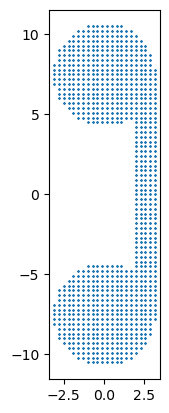

In [85]:
def gen_weld_templates_by_params():
    x_min, x_max = -4.0, 4.0
    y_min, y_max = -12.0, 12.0
    z = 0
    resolution = 0.2
    stem_x_min, stem_x_max = 1.8, 3.2
    stem_y_min, stem_y_max = -8.0, 8.0
    top_center_y = 7.5
    bottom_center_y = -7.5
    radius = 3.20
    
    def dist(pt1, pt2):
        x1, y1 = pt1
        x2, y2 = pt2
        dx = x2-x1
        dy = y2-y1
        return np.sqrt(dx**2 + dy**2)

    points2 = []
    
    for x in np.arange(x_min, x_max, resolution):
        for y in np.arange(y_min, y_max, resolution):
            if dist((x,y), (0, top_center_y)) <= radius:
                points2.append((x,y,z))
            elif dist((x,y), (0, bottom_center_y)) <= radius:
                points2.append((x,y,z))
            elif stem_x_min<=x<=stem_x_max and stem_y_min<=y<=stem_y_max:
                points2.append((x,y,z))

    points1 = [(-x, y, z) for x, y, z in points2]
    return {
            "[": {"xyz": points1},
            "]": {"xyz": points2}
           }

parametric_templates = gen_weld_templates_by_params()


    
def gen_volumetric_weld_templates_by_params():
    x_min, x_max = -4.0, 4.0
    y_min, y_max = -12.0, 12.0
    z_min, z_max = -1, 1
    resolution = 0.3
    stem_x_min, stem_x_max = 1.8, 3.2
    stem_y_min, stem_y_max = -8.0, 8.0
    top_center_y = 7.5
    bottom_center_y = -7.5
    radius = 3.20
    
    def dist(pt1, pt2):
        x1, y1 = pt1
        x2, y2 = pt2
        dx = x2-x1
        dy = y2-y1
        return np.sqrt(dx**2 + dy**2)

    points2 = []
    
    for z in np.arange(z_min, z_max, resolution):
        for x in np.arange(x_min, x_max, resolution):
            for y in np.arange(y_min, y_max, resolution):
                if dist((x,y), (0, top_center_y)) <= radius:
                    points2.append((x,y,z))
                elif dist((x,y), (0, bottom_center_y)) <= radius:
                    points2.append((x,y,z))
                elif stem_x_min<=x<=stem_x_max and stem_y_min<=y<=stem_y_max:
                    points2.append((x,y,z))

    points1 = [(-x, y, z) for x, y, z in points2]
    return {
        "[": {"xyz": points1},
        "]": {"xyz": points2}
       }

volumetric_templates = gen_volumetric_weld_templates_by_params()

def plot_welds(templates, cls="["):
    points = templates[cls]
    dims = len(points[0])
    xs = []
    ys = []
    if dims == 2:
        for x, y in points:
            xs.append(x)
            ys.append(y)
    elif dims == 3:
        for x, y, z in points:
            xs.append(x)
            ys.append(y)
    ax = plt.scatter(xs, ys, s=0.1)
    ax = plt.gca()
    ax.set_aspect('equal')
#     add_staple_patch(ax, 0, 0, 0, 2)

# plot_welds(parametric_templates, "]")
plot_welds(volumetric_templates, "]")



In [52]:
# def _plot_testing(overlay_points):
#     """
#     path - output path
#     points - matrix of x, y, etc cols
#     values - assigned value per point ie predicted/truth cls/inst
#     [optional] overlay_points = [{"xs":[], "ys":[], "cs":_, "marker":_, "label"=_}, ...]
#     """
    
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
# #     ax.set_title(title)
#     im = ax.scatter([-90, -80, -70, -60, -50, -40, -30, -20, -10, 0,10,20,30,40,50,60,70,80,90], [-90, -80, -70, -60, -50, -40, -30, -20, -10, 0,10,20,30,40,50,60,70,80,90],s=0.25,c='grey')
    
# #     _im = None
#     if overlay_points:    
#         for pts in overlay_points:
# #             _im = ax.scatter(pts["xs"], pts["ys"], s=2, c=pts["cs"], marker=pts["marker"])
#             _im = ax.scatter(pts["xs"], pts["ys"], s=pts["ss"], c=pts["cs"], marker=pts["marker"])
#             print(np.unique(pts["cs"], return_inverse=True))
# #             print(pts[])
# #             ims.append(_im)
            
        

#     ax.set_xlabel("x [mm]")
#     ax.set_ylabel("y [mm]")
# #     leg_els = im.legend_elements()
# #     if _im:
# #         leg_els += _im.legend_elements()
# #         print("leg_els")
# #         print(leg_els)
# #         print("_im.legend_elements()")
# #         print(_im.legend_elements())
# #         print("im.legend_elements()")
# #         print(im.legend_elements())
        
# #     legend_ = ax.legend(*im.legend_elements(), bbox_to_anchor=(1.1, 1), loc="upper right")
# #     legend_ = ax.legend(*leg_els, bbox_to_anchor=(1.1, 1), loc="upper right")
# #     ax.add_artist(legend_)
# #     for _im in ims:
# #         _legend = ax.legend(*_im.legend_elements(), bbox_to_anchor=(1.1, 1), loc="upper right")
# #         ax.add_artist(_legend)

# #     ax.text(0.5, -0.5, caption, style='italic', \
# #         horizontalalignment='center', verticalalignment='top', transform=ax.transAxes)
#     axes=plt.gca()
#     axes.set_aspect(1)
# #     if path:
# #         plt.savefig(path, dpi=150)
# #         plt.close()
# #         plt.cla()
# #         plt.clf()
# #     else:
# #         plt.show
#     plt.savefig("./function_check/test1.png", dpi=150)
#     plt.close()
#     plt.cla()
#     plt.clf()
#     plt.show

# overlay_mean_pt2pl = [{\
#   'xs': [-80.4080814534818, -80.46891292783077, 12.690050598167003, 12.675091368473577, 76.12924800589066, 76.05683683241976, 87.61278849506438, 87.6343603478098],\
#   'ys': [-1.4104994201207997, -1.4201994437698928, 0.5671794606719639, 0.5690492565029803, 1.0426517949247163, 1.0340038231892827, 1.6833320733939061, 1.675376535498944],\
#   'ss': [20, 2, 20, 2, 20, 2, 20, 2],\
#   'cs': ['orange', 'red', 'orange', 'red', 'orange', 'red', 'orange', 'red'],\
#   'marker': 's',\
#   'label': 'mean_pt2pl'}]

# _plot_testing(overlay_mean_pt2pl)

(array(['orange', 'red'], dtype='<U6'), array([0, 1, 0, 1, 0, 1, 0, 1], dtype=int64))


<Figure size 640x480 with 0 Axes>